# Running experiments for our local calibration method

In [1]:
import os
import time
from os import path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nonconformist.cp import IcpRegressor
from nonconformist.nc import NcFactory
from sklearn.ensemble import RandomForestRegressor

from lcv.cqr import ConformalizedQuantileRegression
from lcv.locart import LocalRegressionSplit, LocartSplit, MondrianRegressionSplit
from lcv.locluster import KmeansSplit
from lcv.models import QuantileGradientBoosting
from lcv.scores import RegressionScore, QuantileScore
from lcv.simulation import simulation
from lcv.utils import compute_interval_length, real_coverage, split

original_path = os.getcwd()

# figure path
images_dir = "figures"

## Simulated datasets

We will also need to compute conditional and real coverage. For that, we can compute coverage with the following function:

In [2]:
# methods to compute coverage
def real_coverage(model_preds, y_mat):
    r = np.zeros(model_preds.shape[0])
    for i in range(model_preds.shape[0]):
        r[i] = np.mean(np.logical_and(y_mat[i,:] >= model_preds[i, 0], y_mat[i, :] <= model_preds[i, 1]))
    return r

def locart_coverage(locart_model, X_grid, y_mat):
    r = np.zeros(X_grid.shape[0])
    for i in range(X_grid.shape[0]):
        new_X = np.tile(X_grid[i, :], (y_mat.shape[1], 1))
        r[i] = np.unique(locart_model.predict_coverage(new_X, y_mat[i, :], marginal = False)) 
    return r

def uniform_coverage(locart_model, X_grid, y_mat):
    r = np.zeros(X_grid.shape[0])
    for i in range(X_grid.shape[0]):
        new_X = np.tile(X_grid[i, :], (y_mat.shape[1], 1))
        # marginal
        r[i] = np.unique(locart_model.predict_coverage_uniform(new_X, y_mat[i, :], marginal = False))
        
    return r

# methods to compute interval length
def compute_interval_length(predictions):
    return(predictions[:, 1] - predictions[:, 0])

### Testing pruning

Testing our pruning approach versus other decision trees regarding conditional coverage:

In [4]:
def test_pruning(kind = "homoscedastic", 
           n = 10000,
           d = 20, 
           coef = 2,
           hetero_value = 1, 
           asym_value = 0.6,
           random_seed = 750,
           sig = 0.05,
           B_x = 4000,
           B_y = 1000,
           grid_min_samples = np.array([100, 500, 1000, 1500, 2000]),
           type_score = "regression",
           base_model = RandomForestRegressor,
           split_calib = False,
           **kwargs):
    # simulating data and then splitting into train and calibration sets
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, asym_value = asym_value)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp = split(sim_obj.X, sim_obj.y, test_size = 0.5, calibrate = False)

    # coverage plot elements
    # generating X's features from uniform
    X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
    
    # simulating several y from same X
    r_kind = getattr(sim_obj, kind + "_r")
    y_mat = r_kind(X_test[:, 0], B = B_y)
    
    if type_score == "regression":
        # fitting pruning locart
        locart_prune = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_prune.fit(split_icp["X_train"], split_icp["y_train"])
        locart_prune.calib(split_icp["X_test"], split_icp["y_test"])

         # conditional coverage and interval length
        pred_locart = np.array(locart_prune.predict(X_test, length = 2000))
        cond_locart_real =  real_coverage(pred_locart, y_mat)
        locart_interval_len = compute_interval_length(pred_locart)

        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_med_cover = np.median(cond_locart_real)
        locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_marginal_cov = np.mean(cond_locart_real)
        locart_interval = np.mean(locart_interval_len)

        # list of locart models 
        dist_list = [locart_ave_dist]
        med_coverage_list = [locart_med_cover]
        med_dist_list = [locart_med_dist]
        marg_coverage_list = [locart_ave_marginal_cov]
        int_length_list = [locart_interval]
        methods_names = ["Pruned tree"]

        for min_samples_leaf in grid_min_samples:
            locart = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
            locart.fit(split_icp["X_train"], split_icp["y_train"])
            locart.calib(split_icp["X_test"], split_icp["y_test"], prune_tree = False, min_samples_leaf = min_samples_leaf)
            # computing coverage
            # conditional coverage and interval length
            pred_locart = np.array(locart.predict(X_test, length = 2000))
            cond_coverage=  real_coverage(pred_locart, y_mat)
            locart_interval_len = compute_interval_length(pred_locart)

            # computing metrics
            dist_list.append(np.mean(np.abs(cond_coverage - (1 - sig))))
            marg_coverage_list.append(np.mean(cond_coverage))
            med_coverage_list.append(np.median(cond_coverage))
            med_dist_list.append(np.median(np.abs(cond_coverage - (1 - sig))))
            int_length_list.append(np.mean(locart_interval_len))


            methods_names.append("leafs = " + str(min_samples_leaf))
        
        return pd.DataFrame(data = {"Methods":methods_names,
        "Average distance":dist_list,
        "Average marginal coverage": marg_coverage_list,
        "Average interval length": int_length_list,
        "Median conditional coverage": med_coverage_list,
        "Median distance": med_dist_list})

Analysing coverage for different distributions and CART models: 

Homoscedastic:

In [31]:
test_pruning()

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.949139,0.007975,0.949139,3.995778,0.951,0.006
1,leafs = 100,0.990445,0.040445,0.990445,3.898237,0.991,0.041
2,leafs = 500,0.961198,0.012869,0.961198,3.963129,0.963,0.013
3,leafs = 1000,0.952905,0.008397,0.952905,3.998215,0.954,0.007
4,leafs = 1500,0.950828,0.008020,0.950828,3.981904,0.952,0.006
5,leafs = 2000,0.953681,0.008825,0.953681,3.988737,0.955,0.008


Heteroscedastisc

In [32]:
test_pruning(kind = "heteroscedastic", hetero_value=0.15)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.974418,0.032130,0.974418,4.935242,0.984,0.036
1,leafs = 100,0.982507,0.034229,0.982507,4.785485,0.990,0.040
2,leafs = 500,0.975229,0.032094,0.975229,4.929516,0.984,0.036
3,leafs = 1000,0.960660,0.034701,0.960661,4.959803,0.971,0.038
4,leafs = 1500,0.962742,0.034092,0.962742,5.044207,0.973,0.038
5,leafs = 2000,0.955386,0.036974,0.955386,5.287756,0.965,0.040


Highly heteroscedastic:

In [33]:
test_pruning(kind = "heteroscedastic", hetero_value = 1.5)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.958950,0.025066,0.958950,6.824819,0.963,0.025
1,leafs = 100,0.984262,0.034471,0.984262,6.555294,0.987,0.037
2,leafs = 500,0.967131,0.024972,0.967131,6.787877,0.971,0.024
3,leafs = 1000,0.959009,0.025116,0.959009,6.791946,0.962,0.025
4,leafs = 1500,0.958704,0.025238,0.958704,6.869702,0.963,0.025
5,leafs = 2000,0.954329,0.026072,0.954329,6.889447,0.958,0.026


Asymmetric:

In [34]:
test_pruning(kind = "asymmetric", asym_value = 0.6)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length,Median conditional coverage,Median distance
0,Pruned tree,0.966765,0.026485,0.966765,6.928806,0.973,0.027
1,leafs = 100,0.971221,0.027413,0.971221,6.788606,0.977,0.028
2,leafs = 500,0.971555,0.027892,0.971556,7.020521,0.977,0.029
3,leafs = 1000,0.967439,0.026748,0.967439,6.966743,0.974,0.027
4,leafs = 1500,0.964251,0.026331,0.964251,7.145932,0.971,0.026
5,leafs = 2000,0.957838,0.026620,0.957838,7.310045,0.965,0.025


Highly asymmetric:

In [35]:
test_pruning(kind = "asymmetric", asym_value = 1.6)

KeyboardInterrupt: 

We also analyse the efficiency of splitting locart tree:

In [ ]:
test_pruning(split_calib = True)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length
0,Pruned tree,0.950320,0.009859,0.950320,4.002628
1,leafs = 100,0.928361,0.022044,0.928361,4.018390
2,leafs = 500,0.948185,0.009877,0.948185,3.973476
3,leafs = 1000,0.951646,0.009825,0.951646,3.956951
4,leafs = 1500,0.948069,0.009816,0.948069,3.962286
5,leafs = 2000,0.950452,0.009755,0.950452,4.008328


In [ ]:
test_pruning(split_calib = True, kind = "heteroscedastic", hetero_value=0.15)

,Methods,Average conditional coverage,Average distance,Average marginal coverage,Average interval length
0,Pruned tree,0.970672,0.030356,0.970672,5.584821
1,leafs = 100,0.984912,0.035577,0.984912,5.473791
2,leafs = 500,0.970193,0.030571,0.970193,5.573654
3,leafs = 1000,0.948784,0.036820,0.948784,5.882360
4,leafs = 1500,0.951207,0.035432,0.951207,5.834823
5,leafs = 2000,0.951506,0.035509,0.951506,5.855645


In [ ]:
test_pruning(split_calib = True, kind = "heteroscedastic", hetero_value = 1.5)

In [ ]:
test_pruning(split_calib = True, kind = "asymmetric", asym_value = 0.6)

In [ ]:
test_pruning(split_calib = True, kind = "asymmetric", asym_value = 1.6)

We will first compare our method to other conformal and non conformal methods using $S(\boldsymbol{x}, y) = |g(\boldsymbol{x}) - y|$ (Regression score) as our non conformity score:

### Regression Score

Here we will focus in comparing the regression conformal methods with our method on homoscedastisc, heteroscedastic and asymmetric data with noise. Our method returns diferent thresholds for $t(x)$ while the two commonly used weighted regression and regression split retuns a single threshold $t$. In order to compare these approaches, we define the following functions:

In [3]:
def compute_conformal_statistics(kind = "homoscedastic", 
           n = 20000,
           d = 20, 
           coef = 2,
           hetero_value = 1,
           asym_value = 0.6,
           t_degree = 4,
           random_seed = 1250, 
           sig = 0.05,
           alpha = 0.5,
           B_x = 4000,
           B_y = 1000,
           type_score = "regression",
           base_model = RandomForestRegressor,
           figname_tree = "locart_tree.pdf",
           only_locart = False,
           split_calib = False,
           plot_tree = True,
           n_estimators = 200,
           quantiles = [0.8, 0.85, 0.9, 0.95],
           random_states = [750, 85, 666, 69],
           prop_k = np.arange(2, 11),
           tune_k = True,
           nbins = 20,
           criterion = "squared_error",
           max_depth = None,
           max_leaf_nodes = None,
           min_samples_leaf = 300,
           prune = True,
           **kwargs):
    # generating X's features from uniform
    # testing first if our kind of dataset is the latent one or not
    if(kind != "heteroscedastic_latent"):
        X_test = np.random.uniform(low = -1.5, high = 1.5, size = (B_x, d))
    else:
        X_test = np.column_stack(
            (np.random.binomial(1,p = 0.2, size = B_x),
            np.random.uniform(low = -5, high = 5, size=(B_x, d + 1))))
           
    # simulating data and then splitting into train and calibration sets
    sim_obj = simulation(dim = d, coef = coef, hetero_value = hetero_value, asym_value = asym_value, t_degree = t_degree)
    sim_kind = getattr(sim_obj, kind)
    sim_kind(n, random_seed = random_seed)
    split_icp = split(sim_obj.X, sim_obj.y, test_size = 0.5,calibrate = False)

    # coverage plot elements
    
    # simulating several y from same X
    r_kind = getattr(sim_obj, kind + "_r")
    # testing again if kind is heteroscedastic latent
    if(kind != "heteroscedastic_latent"):
        y_mat = r_kind(X_test[:, 0], B = B_y)
    else:
        y_mat = r_kind(X_test, B = B_y)
        # updating X_test to not use latent variable
        X_test = X_test[:, 1:]
    
    if type_score == "regression":
        if only_locart:
            # fitting locart
            locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
            locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
            locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
            max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)

            # conditional coverage and interval length
            pred_locart = np.array(locart_obj.predict(X_test, length = 2000))
            cond_locart_real =  real_coverage(pred_locart, y_mat)
            locart_interval_len = compute_interval_length(pred_locart)

            # several measures
            locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
            locart_med_cover = np.median(cond_locart_real)
            locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
            locart_ave_marginal_cov = np.mean(cond_locart_real)
            locart_interval = np.mean(locart_interval_len)

            all_results =  pd.DataFrame(data = {"Methods":["LOCART"],
                "Average distance":[locart_ave_dist],
                "Median conditional coverage":[locart_med_cover],
                "Median distance":[locart_med_dist],
                "Average marginal coverage":[locart_ave_marginal_cov],
                "Average interval length":[locart_interval]})

            # plotting boxplots
            # gathering all data into a data frame
            boxplot_data = pd.melt(pd.DataFrame(data = {"Methods":list(np.repeat(["LOCART"], locart_interval_len.shape[0])),
                                            "Interval length": list(locart_interval_len),
                                            "Coverage": list(cond_locart_real)}), id_vars = ['Methods'], 
                                            value_vars = ['Interval length', 'Coverage'])

            plt.figure(figsize=(10, 6))
            sns.catplot(data = boxplot_data,
            y = 'Methods', x = 'value', col = 'variable', kind = 'box', sharex= False)
            plt.tight_layout()
            plt.show()

            # plotting tree to visualize partitions
            if plot_tree:
                plt.figure(figsize=(25, 20))
                locart_obj.plot_locart()
                plt.savefig(f"{images_dir}/{figname_tree}")
                plt.show()
            
            return [all_results, locart_obj]
        # fitting mondrian regression split
        print("Fitting mondrian regression split")
        start_mondrian_split = time.time()
        micp = MondrianRegressionSplit(base_model, alpha = sig, k = nbins, **kwargs)
        micp.fit(split_icp["X_train"], split_icp["y_train"])
        micp.calibrate(split_icp["X_test"], split_icp["y_test"])

        end_mondrian_split = time.time() - start_mondrian_split
        print("Time Elapsed to fit mondrian regression split: ", end_mondrian_split)

        print("Computing metrics")
        start_mondrian_split = time.time()
        # mondrian icp real coverage and interval length
        micp_cond_r_real = real_coverage(micp.predict(X_test), y_mat)
        micp_interval_len = compute_interval_length(micp.predict(X_test))

        # computing micp measures
        micp_ave_dist = np.mean(np.abs(micp_cond_r_real - (1 - sig)))
        micp_ave_marginal_cov = np.mean(micp_cond_r_real)
        micp_med_cover = np.median(micp_cond_r_real)
        micp_med_dist = np.median(np.abs(micp_cond_r_real - (1 - sig)))
        micp_interval = np.mean(micp_interval_len)

        end_mondrian_split = time.time() - start_mondrian_split
        print("Time Elapsed to compute statistics for mondrian regression split: ", end_mondrian_split)

        print("Fitting locluster")
        start_locluster = time.time()
        locluster_obj = KmeansSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, **kwargs)
        locluster_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locluster_obj.calib(split_icp["X_test"], split_icp["y_test"], tune_k = tune_k, 
        prop_k = prop_k, n_estimators = n_estimators, quantiles = quantiles, random_states = random_states)

        end_locluster = time.time()

        print("Computing metrics")
        start_locluster = time.time()
        # conditional coverage and interval length
        pred_locluster = np.array(locluster_obj.predict(X_test, length = 2000))
        cond_locluster_real =  real_coverage(pred_locluster, y_mat)
        locluster_interval_len = compute_interval_length(pred_locluster)

        # several measures
        locluster_ave_dist = np.mean(np.abs(cond_locluster_real - (1 - sig)))
        locluster_med_cover = np.median(cond_locluster_real)
        locluster_med_dist = np.median(np.abs(cond_locluster_real - (1 - sig)))
        locluster_ave_marginal_cov = np.mean(cond_locluster_real)
        locluster_interval = np.mean(locluster_interval_len)

        end_locluster = time.time() - start_locluster
        print("Time Elapsed to compute metrics for Locluster: ", end_locluster)


        print("Fitting locart")
        start_loc = time.time()
        # fitting locart
        locart_obj = LocartSplit(nc_score = RegressionScore, base_model = base_model, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion, prune_tree = prune)
        
        end_loc = time.time() - start_loc
        print("Time Elapsed to fit Locart: ", end_loc)

        print("Computing metrics")
        start_loc = time.time()
        # conditional coverage and interval length
        pred_locart = np.array(locart_obj.predict(X_test, length = 2000))
        cond_locart_real =  real_coverage(pred_locart, y_mat)
        locart_interval_len = compute_interval_length(pred_locart)

        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_med_cover = np.median(cond_locart_real)
        locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_marginal_cov = np.mean(cond_locart_real)
        locart_interval = np.mean(locart_interval_len)
        end_loc = time.time() - start_loc
        print("Time Elapsed to compute metrics for Locart: ", end_loc)

        # fitting default regression split
        print("Fitting regression split")
        start_split = time.time()
        model = base_model(**kwargs)
        nc = NcFactory.create_nc(model)
        icp = IcpRegressor(nc)
        icp.fit(split_icp["X_train"], split_icp["y_train"])
        icp.calibrate(split_icp["X_test"], split_icp["y_test"])

        end_split = time.time() - start_split
        print("Time Elapsed to fit regression split: ", end_split)

        print("Computing metrics")
        start_split = time.time()
        # icp real coverage and interval length
        icp_cond_r_real = real_coverage(icp.predict(X_test, significance = sig), y_mat)
        icp_interval_len = compute_interval_length(icp.predict(X_test, significance = sig))

        # computing icp measures
        icp_ave_dist = np.mean(np.abs(icp_cond_r_real - (1 - sig)))
        icp_ave_marginal_cov = np.mean(icp_cond_r_real)
        icp_med_cover = np.median(icp_cond_r_real)
        icp_med_dist = np.median(np.abs(icp_cond_r_real - (1 - sig)))
        icp_interval = np.mean(icp_interval_len)

        end_split = time.time() - start_split
        print("Time Elapsed to compute statistics for regression split: ", end_split)

        # fitting wighted regression split
        print("Fitting weighted regression split")
        start_weighted_split = time.time()
        wicp = LocalRegressionSplit(base_model, alpha = sig, **kwargs)
        wicp.fit(split_icp["X_train"], split_icp["y_train"])
        wicp.calibrate(split_icp["X_test"], split_icp["y_test"])

        end_weighted_split = time.time() - start_weighted_split
        print("Time Elapsed to fit weighted regression split: ", end_weighted_split)

        print("Computing metrics")
        start_weighted_split = time.time()
        # weighted icp real coverage and interval length
        wicp_cond_r_real = real_coverage(wicp.predict(X_test), y_mat)
        wicp_interval_len = compute_interval_length(wicp.predict(X_test))

        # computing wicp measures
        wicp_ave_dist = np.mean(np.abs(wicp_cond_r_real - (1 - sig)))
        wicp_ave_marginal_cov = np.mean(wicp_cond_r_real)
        wicp_med_cover = np.median(wicp_cond_r_real)
        wicp_med_dist = np.median(np.abs(wicp_cond_r_real - (1 - sig)))
        wicp_interval = np.mean(wicp_interval_len)

        end_weighted_split = time.time() - start_weighted_split
        print("Time Elapsed to compute statistics for weighted regression split: ", end_weighted_split)


        print("Fitting euclidean regression split")
        start_euclidean = time.time()
        # fitting uniform binning regression split
        locart_obj.uniform_binning(split_icp["X_test"], split_icp["y_test"])
        end_euclidean = time.time() - start_euclidean
        print("Time Elapsed to fit euclidean regression split: ", end_euclidean)

        # computing local coverage to uniform binning
        print("Computing metrics")
        start_euclidean = time.time()
        pred_uniform = np.array(locart_obj.predict(X_test, length = 2000, type_model = "euclidean"))
        uniform_cond_r_real = real_coverage(pred_uniform, y_mat)
        uniform_interval_len = compute_interval_length(pred_uniform)

        # computing euclidean binning measures
        uniform_ave_dist = np.mean(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_ave_marginal_cov = np.mean(uniform_cond_r_real)
        uniform_med_cover = np.median(uniform_cond_r_real)
        uniform_med_dist = np.median(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_interval = np.mean(uniform_interval_len)

        end_euclidean = time.time() - start_euclidean
        print("Time Elapsed to compute statistics for euclidean regression split: ", end_euclidean)

        
        all_results =  pd.DataFrame(data = {"Methods":["LOCLUSTER", "LOCART", "Regresion split", "Weighted regression split", "Mondrian regression split", 
        "Euclidean regression split"],
        "Average distance":[locluster_ave_dist, locart_ave_dist,  icp_ave_dist, wicp_ave_dist, micp_ave_dist, uniform_ave_dist],
        "Median conditional coverage":[locluster_med_cover, locart_med_cover, icp_med_cover, wicp_med_cover, micp_med_cover, uniform_med_cover],
        "Median distance":[locluster_med_dist, locart_med_dist, icp_med_dist, wicp_med_dist, micp_med_dist, uniform_med_dist],
        "Average marginal coverage":[locluster_ave_marginal_cov, locart_ave_marginal_cov, icp_ave_marginal_cov, wicp_ave_marginal_cov, micp_ave_marginal_cov,
        uniform_ave_marginal_cov],
        "Average interval length":[locluster_interval, locart_interval, icp_interval, wicp_interval, micp_interval, uniform_interval]})

        # plotting boxplots
        # gathering all data into a data frame
        boxplot_data = pd.melt(pd.DataFrame(data = {"Methods":list(np.repeat(["LOCLUSTER", "LOCART", "Regresion split", 
        "Weighted regression split", "Mondrian regression split", "Euclidean regression split"],
        locart_interval_len.shape[0])),
        "Interval length": list(np.concatenate((locluster_interval_len, locart_interval_len, icp_interval_len, wicp_interval_len, micp_interval_len,
         uniform_interval_len))),
        "Coverage": list(np.concatenate((cond_locluster_real, cond_locart_real, icp_cond_r_real, wicp_cond_r_real, micp_cond_r_real,
         uniform_cond_r_real)))
        }), id_vars = ['Methods'], value_vars = ['Interval length', 'Coverage'])

        plt.figure(figsize=(10, 6))
        sns.catplot(data = boxplot_data,
        y = 'Methods', x = 'value', col = 'variable', kind = 'box', sharex= False)
        plt.tight_layout()
        plt.show()
    
    elif type_score == "quantile":
        # fitting gradient boosting quantile regression
        # first fitting quantile split
        model = base_model(alpha = sig, **kwargs)
        cqr = ConformalizedQuantileRegression(model, alpha = sig)
        cqr.fit(split_icp["X_train"], split_icp["y_train"])
        cqr.calib(split_icp["X_test"], split_icp["y_test"])
        
        # icp real coverage and interval length
        pred_cqr = cqr.predict(X_test)
        cqr_cond_r_real = real_coverage(pred_cqr, y_mat)
        cqr_interval_len = compute_interval_length(pred_cqr)

        # computing icp measures
        cqr_ave_dist = np.mean(np.abs(cqr_cond_r_real - (1 - sig)))
        cqr_ave_marginal_cov = np.mean(cqr_cond_r_real)
        cqr_med_cover = np.median(cqr_cond_r_real)
        cqr_med_dist = np.median(np.abs(cqr_cond_r_real - (1 - sig)))
        cqr_interval = np.mean(cqr_interval_len)

        # fitting locluster
        locluster_obj = KmeansSplit(nc_score = QuantileScore, base_model = base_model, alpha = sig, **kwargs)
        locluster_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locluster_obj.calib(split_icp["X_test"], split_icp["y_test"], tune_k = tune_k, 
        prop_k = prop_k, n_estimators = n_estimators, quantiles = quantiles, random_states = random_states)


        # conditional coverage and interval length
        pred_locluster = np.array(locluster_obj.predict(X_test, length = 2000))
        cond_locluster_real =  real_coverage(pred_locluster, y_mat)
        locluster_interval_len = compute_interval_length(pred_locluster)

        # several measures
        locluster_ave_dist = np.mean(np.abs(cond_locluster_real - (1 - sig)))
        locluster_med_cover = np.median(cond_locluster_real)
        locluster_med_dist = np.median(np.abs(cond_locluster_real - (1 - sig)))
        locluster_ave_marginal_cov = np.mean(cond_locluster_real)
        locluster_interval = np.mean(locluster_interval_len)


        # fitting locart
        locart_obj = LocartSplit(nc_score = QuantileScore, base_model = base_model,
        base_model_type=True, alpha = sig, split_calib = split_calib, **kwargs)
        locart_obj.fit(split_icp["X_train"], split_icp["y_train"])
        locart_obj.calib(split_icp["X_test"], split_icp["y_test"], max_depth = max_depth, 
        max_leaf_nodes = max_leaf_nodes, min_samples_leaf = min_samples_leaf, criterion = criterion)

        # conditional coverage and interval length
        pred_locart = locart_obj.predict(X_test, length=2000)
        cond_locart_real = real_coverage(pred_locart, y_mat)
        locart_interval_len = compute_interval_length(pred_locart)
        
        # several measures
        locart_ave_dist = np.mean(np.abs(cond_locart_real - (1 - sig)))
        locart_med_cover = np.median(cond_locart_real)
        locart_med_dist = np.median(np.abs(cond_locart_real - (1 - sig)))
        locart_ave_marginal_cov = np.mean(cond_locart_real)
        locart_interval = np.mean(locart_interval_len)

        # fitting euclidean binning
        locart_obj.uniform_binning(split_icp["X_test"], split_icp["y_test"])

        # computing local coverage to uniform binning
        pred_uniform = locart_obj.predict(
            X_test, length=2000, type_model="euclidean"
        )

        uniform_cond_r_real = real_coverage(pred_uniform, y_mat)
        uniform_interval_len = compute_interval_length(pred_uniform)

        # computing euclidean binning measures
        uniform_ave_dist = np.mean(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_ave_marginal_cov = np.mean(uniform_cond_r_real)
        uniform_med_cover = np.median(uniform_cond_r_real)
        uniform_med_dist = np.median(np.abs(uniform_cond_r_real - (1 - sig)))
        uniform_interval = np.mean(uniform_interval_len)

        # fitting raw quantilic regression
        qgb_obj = model
        qgb_obj.fit(split_icp["X_train"], split_icp["y_train"])

        pred_qgb = qgb_obj.predict(X_test)
        cond_qgb_real = real_coverage(pred_qgb, y_mat)
        qgb_interval_len = compute_interval_length(pred_qgb)

        # computing raw quantilic measures
        qgb_ave_dist = np.mean(np.abs(cond_qgb_real - (1 - sig)))
        qgb_ave_marginal_cov = np.mean(cond_qgb_real)
        qgb_med_cover = np.median(cond_qgb_real)
        qgb_med_dist = np.median(np.abs(cond_qgb_real - (1 - sig)))
        qgb_interval = np.mean(qgb_interval_len)
    
        
        all_results =  pd.DataFrame(data = {"Methods":["LOCLUSTER", "LOCART", "CQR", "Euclidean CQR", "Quantilic Regression"],
        "Average distance":[locluster_ave_dist, locart_ave_dist, cqr_ave_dist, uniform_ave_dist, qgb_ave_dist],
        "Median conditional coverage":[locluster_med_cover, locart_med_cover, cqr_med_cover, uniform_med_cover, qgb_med_cover],
        "Median distance":[locluster_med_dist, locart_med_dist, cqr_med_dist, uniform_med_dist, qgb_med_dist],
        "Average marginal coverage":[locluster_ave_marginal_cov, locart_ave_marginal_cov, cqr_ave_marginal_cov, uniform_ave_marginal_cov, qgb_ave_marginal_cov],
        "Average interval length":[locluster_interval, locart_interval, cqr_interval, uniform_interval, qgb_interval]})

        # plotting boxplots
        # gathering all data into a data frame
        boxplot_data = pd.melt(pd.DataFrame(data = {"Methods":list(np.repeat(["LOCLUSTER", "LOCART", "CQR", 
        "Euclidean CQR", "Quantilic Regression"],
        locart_interval_len.shape[0])),
        "Interval length": list(np.concatenate((locluster_interval_len, locart_interval_len, cqr_interval_len, uniform_interval_len, qgb_interval_len))),
        "Coverage": list(np.concatenate((cond_locluster_real, cond_locart_real, cqr_cond_r_real, uniform_cond_r_real, cond_qgb_real)))
        }), id_vars = ['Methods'], value_vars = ['Interval length', 'Coverage'])

        plt.figure(figsize=(10, 6))
        sns.catplot(data = boxplot_data,
        y = 'Methods', x = 'value', col = 'variable', kind = 'box', sharex= False)
        plt.tight_layout()
        plt.show()
        
    # plotting tree to visualize partitions
    if plot_tree:
        plt.figure(figsize=(25, 20))
        locart_obj.plot_locart()
        plt.savefig(f"{images_dir}/{figname_tree}")
        plt.show()
    
    return [all_results, locart_obj]

For now, we will fix $d = 20$, $\beta_1 = 2$ as some of the simulation parameters and vary the distribution of the data to compare our method to the usual split conformal methods, including the euclidean version of them:

### Normal Homoscedastic data:

Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  180.94106769561768
Fitting locart
Time Elapsed to fit Locart:  27.940259218215942
Computing metrics
Time Elapsed to compute metrics for Locart:  162.51067185401917
Fitting regression split
Time Elapsed to fit regression split:  30.536574125289917
Computing metrics
Time Elapsed to compute statistics for regression split:  0.8109991550445557
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  52.51150989532471
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.9271340370178223
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.5921318531036377
Computing metrics
Time Elapsed to compute statistics for euclidean regression split:  163.2710280418396


<Figure size 720x432 with 0 Axes>

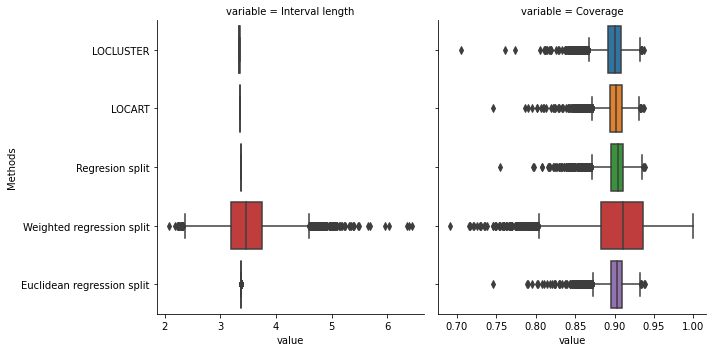

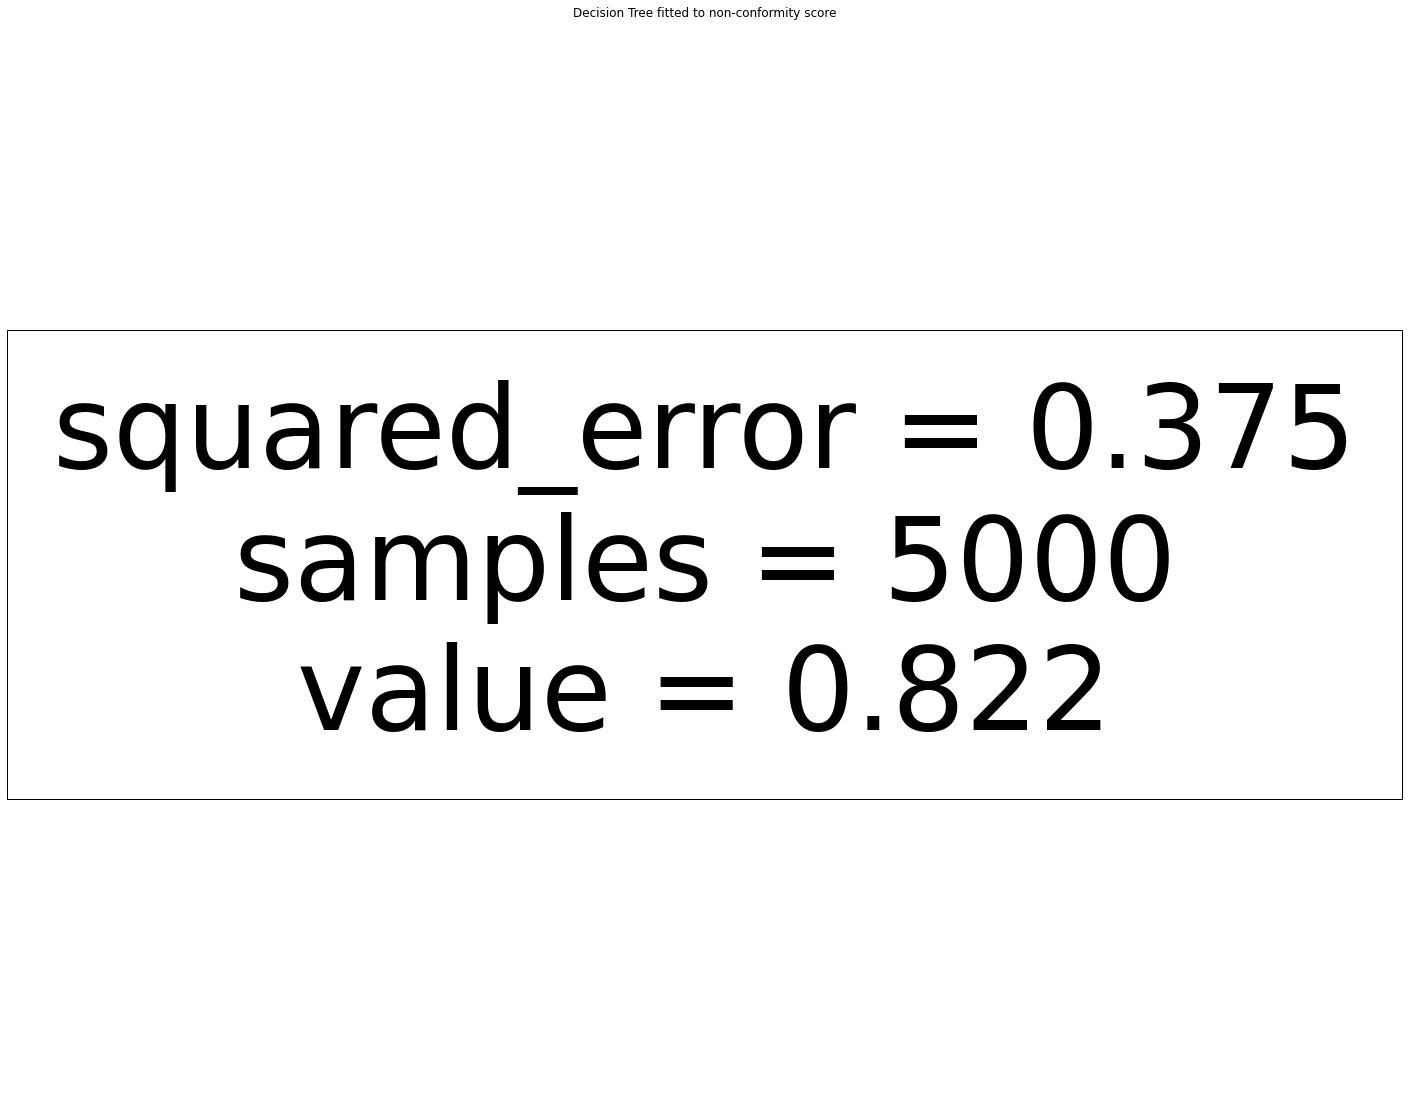

<Figure size 432x288 with 0 Axes>

In [10]:
locart_cov_values = compute_conformal_statistics(figname_tree = "locart_tree_homoscedastic_RF_d_20.pdf",
split_calib = True, B_x = 10000, sig  = 0.1)

In [11]:
locart_cov_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.009965,0.901,0.008,0.899196,3.344471
1,LOCART,0.009944,0.902,0.008,0.900482,3.355997
2,Regresion split,0.010238,0.904,0.008,0.902096,3.373200
3,Weighted regression split,0.033375,0.911,0.029,0.906515,3.493964
4,Euclidean regression split,0.010098,0.903,0.008,0.901723,3.368470


### Heteroscedastic data

Taking $\sigma = \sqrt{\gamma + \beta_1 \cdot |X_1|}$ with $\gamma = 0.25$

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  27.841729640960693
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  1.9867963790893555
Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  178.96405053138733
Fitting locart
Time Elapsed to fit Locart:  26.632879972457886
Computing metrics
Time Elapsed to compute metrics for Locart:  133.26701021194458
Fitting regression split
Time Elapsed to fit regression split:  26.63515567779541
Computing metrics
Time Elapsed to compute statistics for regression split:  0.6590406894683838
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  39.623615026474
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.6259636878967285
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.5139048099517822
Computing metrics
Time Elapsed to compute statistics for euclidea

<Figure size 720x432 with 0 Axes>

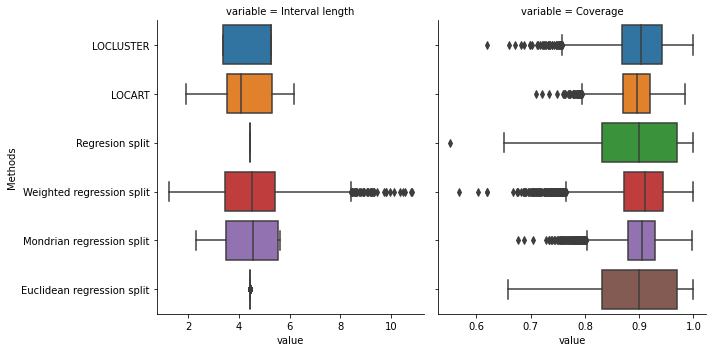

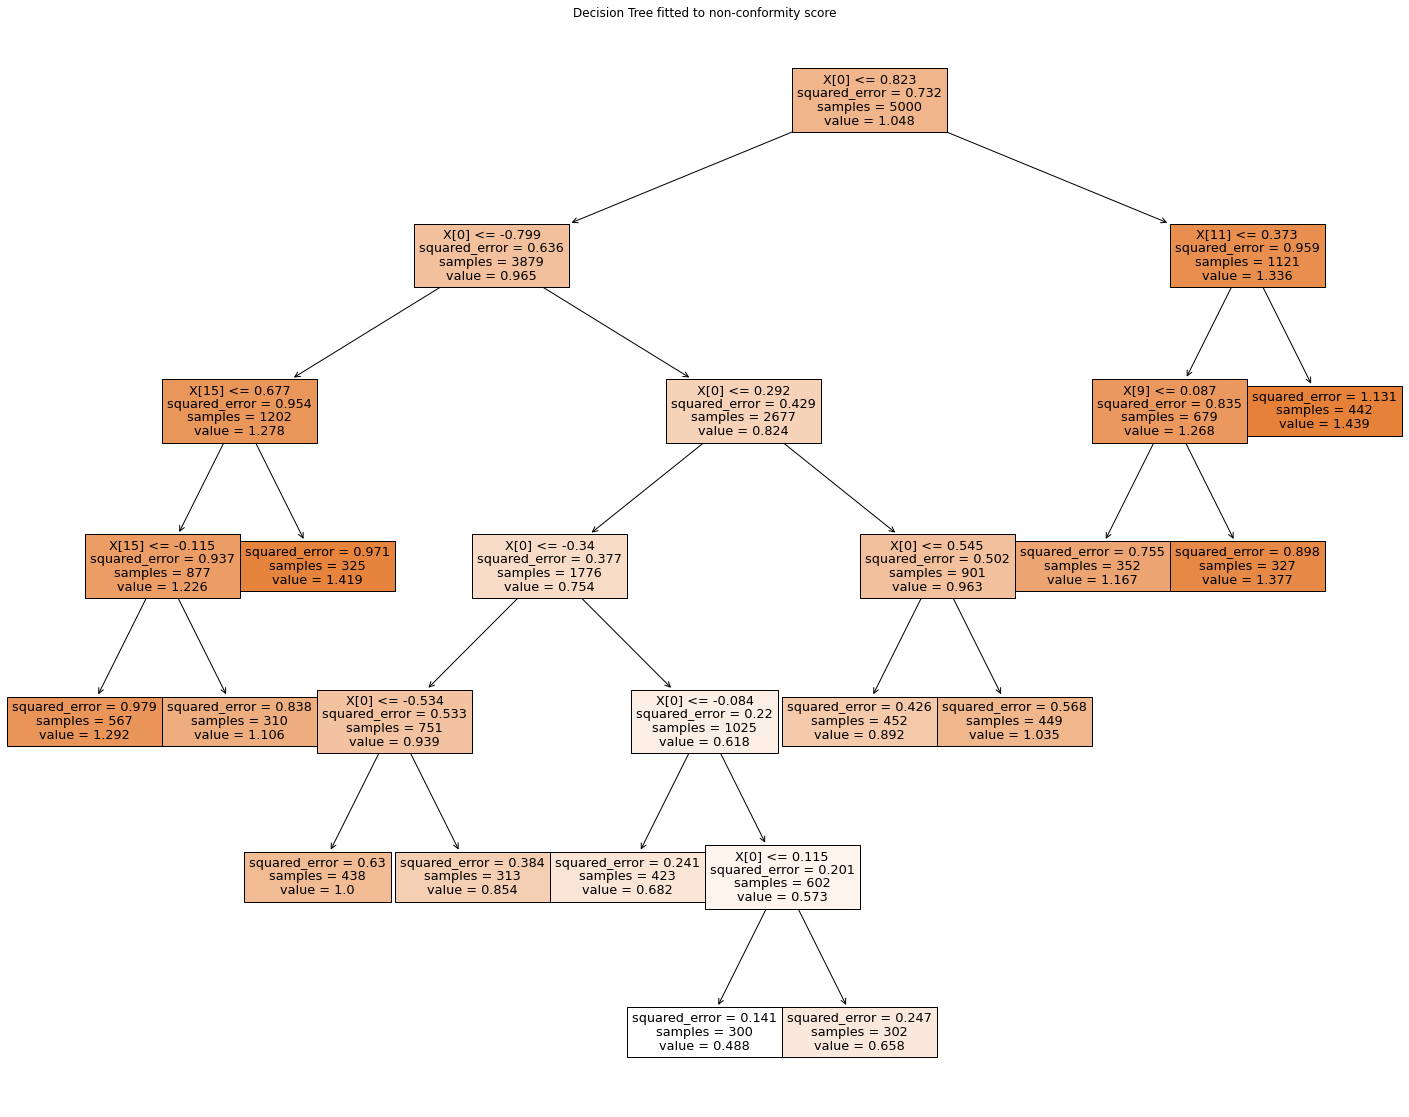

<Figure size 432x288 with 0 Axes>

In [4]:
values = compute_conformal_statistics(kind = "heteroscedastic", d = 20,
figname_tree = "locart_tree_heteroscedastic_RF_d_20_split.pdf", B_x = 10000, split_calib = True,
hetero_value = 0.25, sig = 0.1, nbins = 10)

In [6]:
values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.043836,0.904,0.037,0.903289,4.367866
1,LOCART,0.028591,0.896,0.025,0.894416,4.224505
2,Regresion split,0.065740,0.899,0.069,0.897681,4.419332
3,Weighted regression split,0.043035,0.910,0.038,0.902941,4.454389
4,Mondrian regression split,0.030973,0.905,0.026,0.902931,4.324815
5,Euclidean regression split,0.065720,0.900,0.069,0.897937,4.422637


### Asymmetric residuals (gamma)

Taking $\alpha = \beta = 1 + \eta \cdot |X_1|$ for $\eta = 0.7$:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  36.11582589149475
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  2.0100817680358887
Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  176.97075653076172
Fitting locart
Time Elapsed to fit Locart:  34.77115488052368
Computing metrics
Time Elapsed to compute metrics for Locart:  135.58830213546753
Fitting regression split
Time Elapsed to fit regression split:  34.75518012046814
Computing metrics
Time Elapsed to compute statistics for regression split:  0.698704719543457
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  50.13314247131348
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.7132720947265625
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.515289306640625
Computing metrics
Time Elapsed to compute statistics for euclidean 

<Figure size 720x432 with 0 Axes>

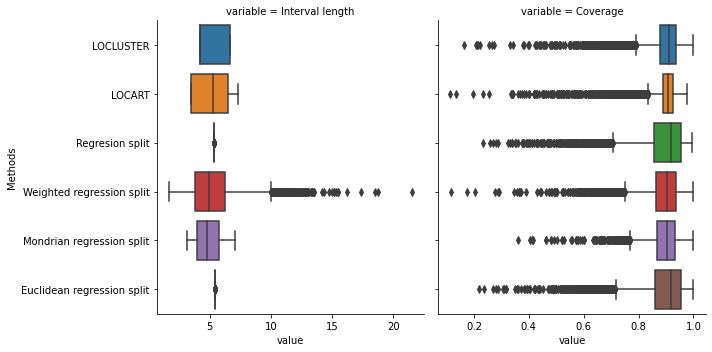

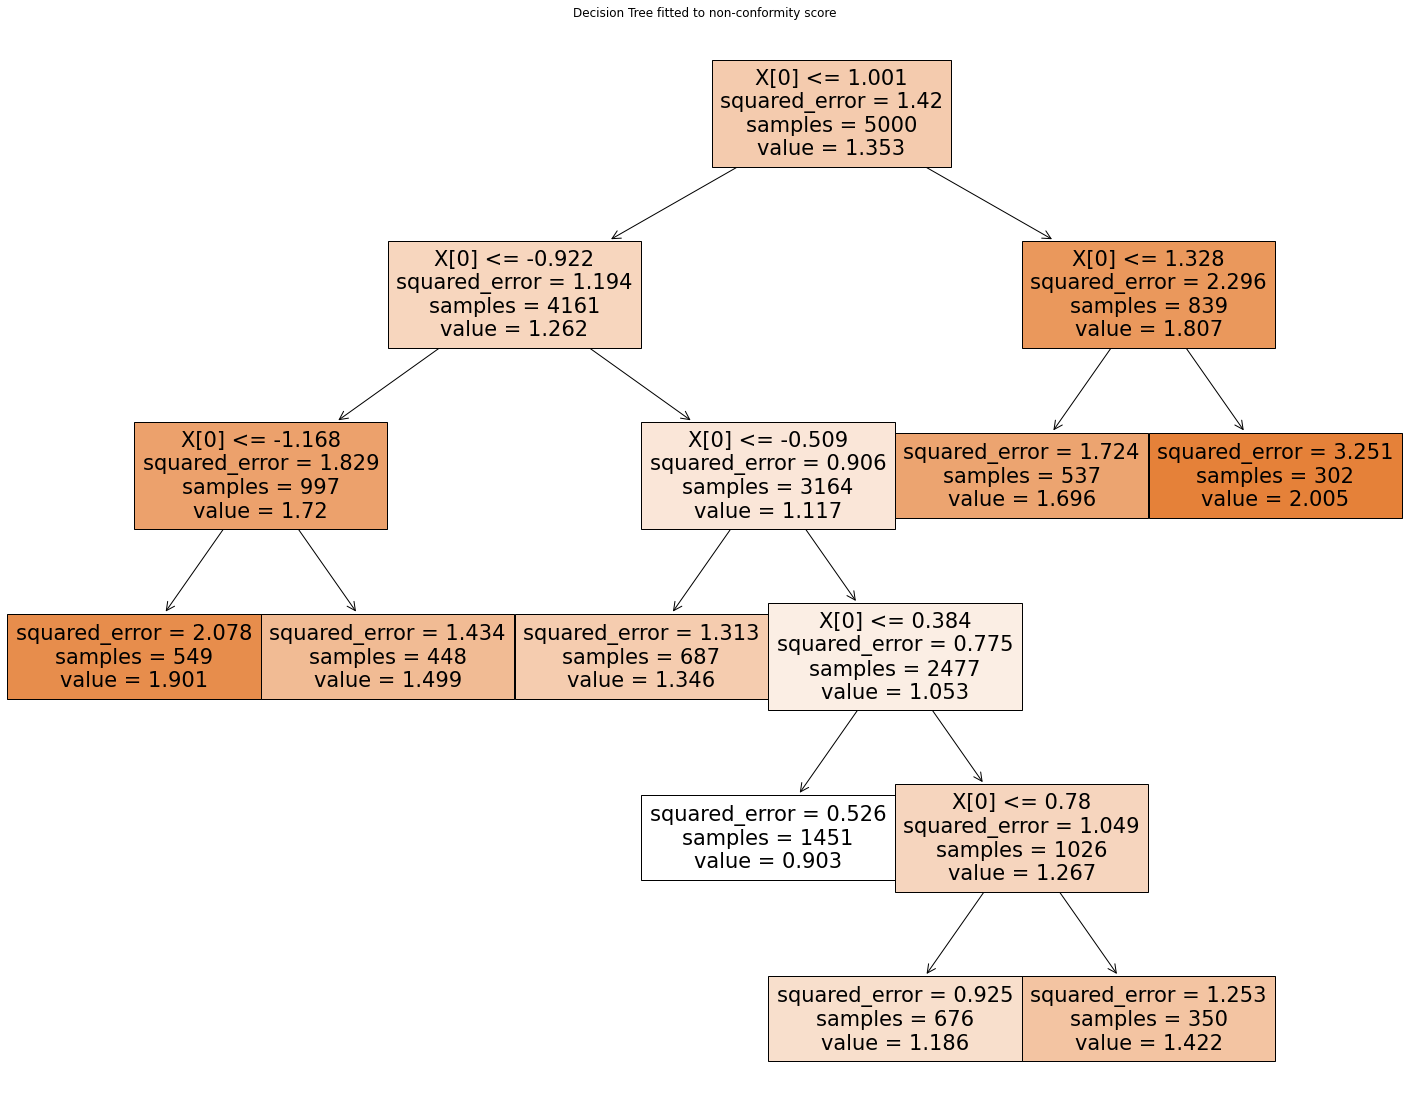

<Figure size 432x288 with 0 Axes>

In [7]:
values_asym = compute_conformal_statistics(kind = "asymmetric", d = 20,
figname_tree = "locart_tree_asymmetric_RF_d_20_split.pdf", B_x = 10000, split_calib = True,
asym_value = 0.6, sig = 0.1, nbins = 10)

In [9]:
values_asym[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.042163,0.912,0.031,0.897048,5.237288
1,LOCART,0.031280,0.909,0.020,0.896571,5.156475
2,Regresion split,0.063815,0.917,0.052,0.890839,5.395159
3,Weighted regression split,0.049262,0.904,0.037,0.889541,5.219184
4,Mondrian regression split,0.041071,0.904,0.033,0.894421,4.955858
5,Euclidean regression split,0.062070,0.919,0.052,0.893652,5.431025


Now taking $\eta = 1.5$:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  47.951664447784424
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  2.6361083984375
Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  250.89781594276428
Fitting locart
Time Elapsed to fit Locart:  41.445427894592285
Computing metrics
Time Elapsed to compute metrics for Locart:  182.68139815330505
Fitting regression split
Time Elapsed to fit regression split:  39.56082773208618
Computing metrics
Time Elapsed to compute statistics for regression split:  0.6641113758087158
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  59.616700410842896
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.694654941558838
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.5416591167449951
Computing metrics
Time Elapsed to compute statistics for euclidean

<Figure size 720x432 with 0 Axes>

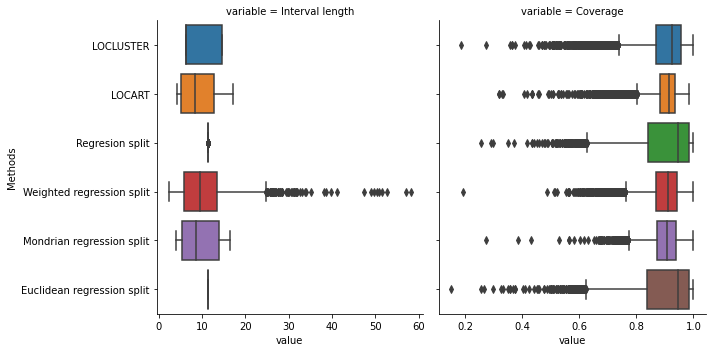

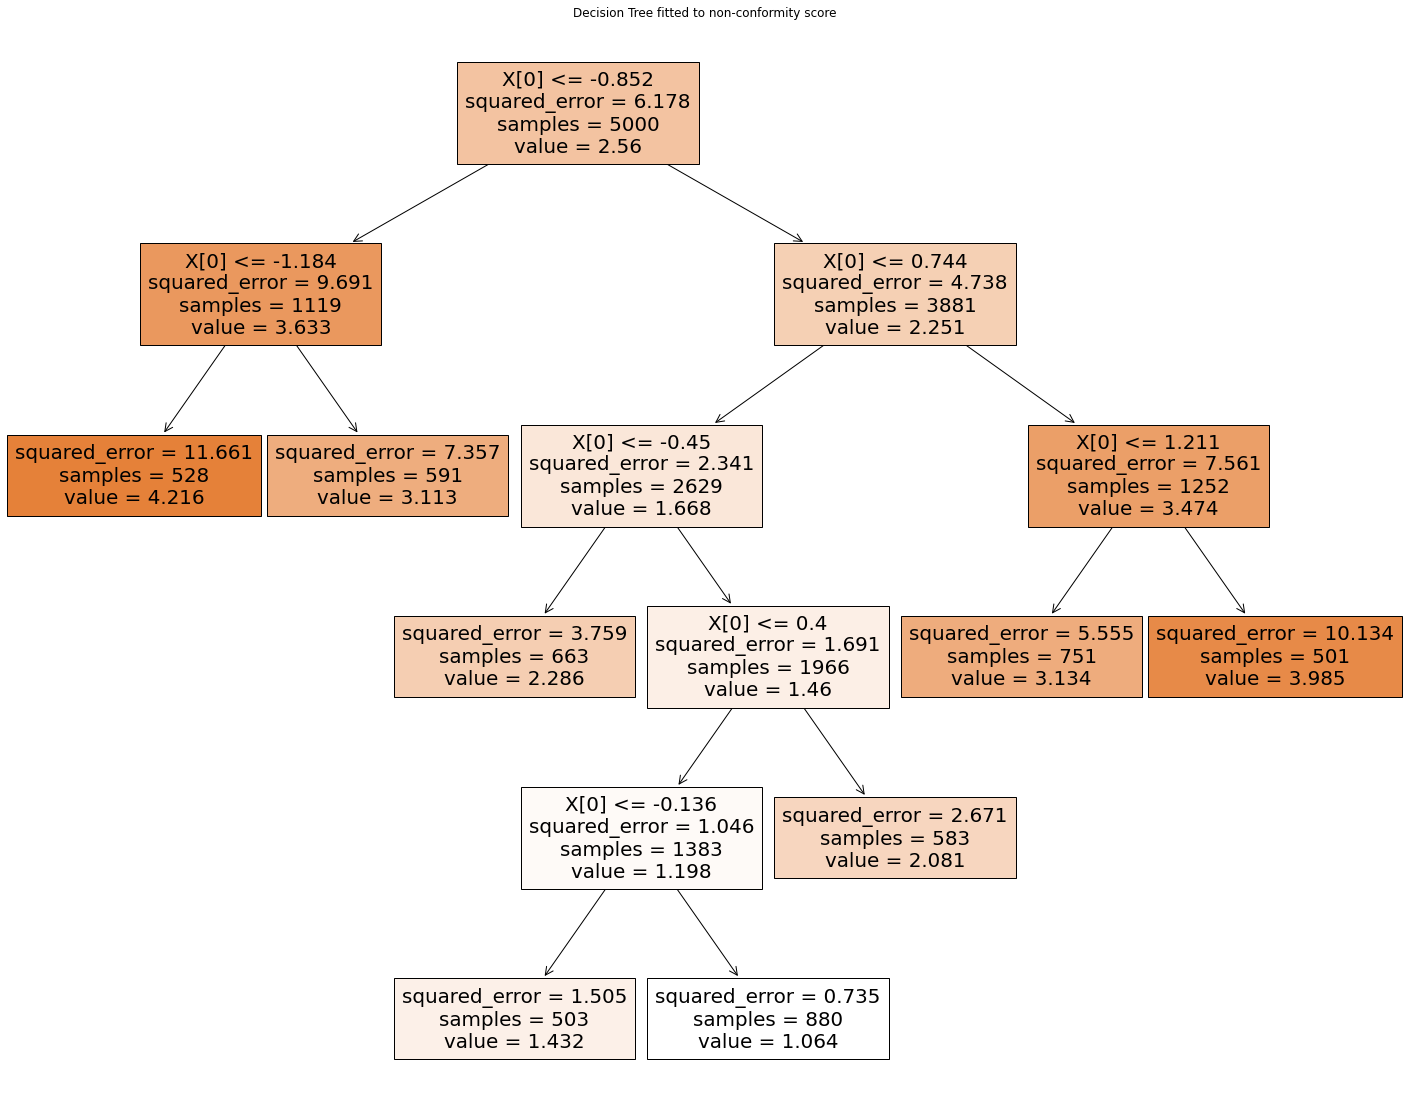

<Figure size 432x288 with 0 Axes>

In [13]:
values_asym = compute_conformal_statistics(kind = "asymmetric", d = 20,
figname_tree = "locart_tree_asymmetric_RF_d_20_eta_1_5_split.pdf", B_x = 10000, split_calib = True,
asym_value = 1.5, sig = 0.1, min_samples_leaf= 500, nbins = 10)

In [14]:
values_asym[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.060808,0.9240,0.050,0.899203,10.445173
1,LOCART,0.037802,0.9130,0.030,0.900853,9.957536
2,Regresion split,0.084771,0.9460,0.080,0.902770,11.361455
3,Weighted regression split,0.047146,0.9120,0.038,0.897719,10.087937
4,Mondrian regression split,0.040563,0.9075,0.034,0.901231,9.645288
5,Euclidean regression split,0.085811,0.9450,0.080,0.900933,11.294339


### Homoscedastic t distribution

taking $\nu = 4$

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  39.718435287475586
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  2.490421772003174
Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  231.68664288520813
Fitting locart
Time Elapsed to fit Locart:  39.975523710250854
Computing metrics
Time Elapsed to compute metrics for Locart:  180.8972134590149
Fitting regression split
Time Elapsed to fit regression split:  39.61167025566101
Computing metrics
Time Elapsed to compute statistics for regression split:  0.8911564350128174
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  64.53544187545776
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  2.088141679763794
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.6156949996948242
Computing metrics
Time Elapsed to compute statistics for euclidean

<Figure size 720x432 with 0 Axes>

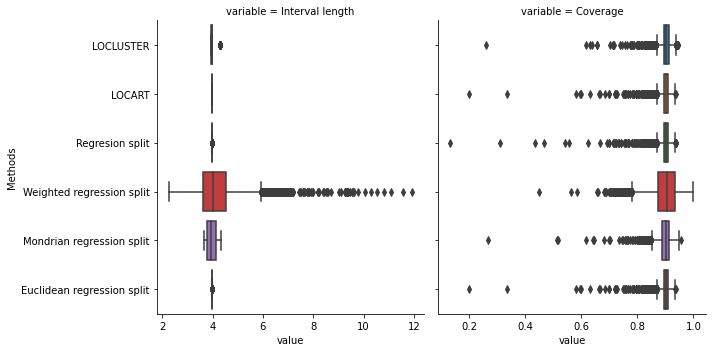

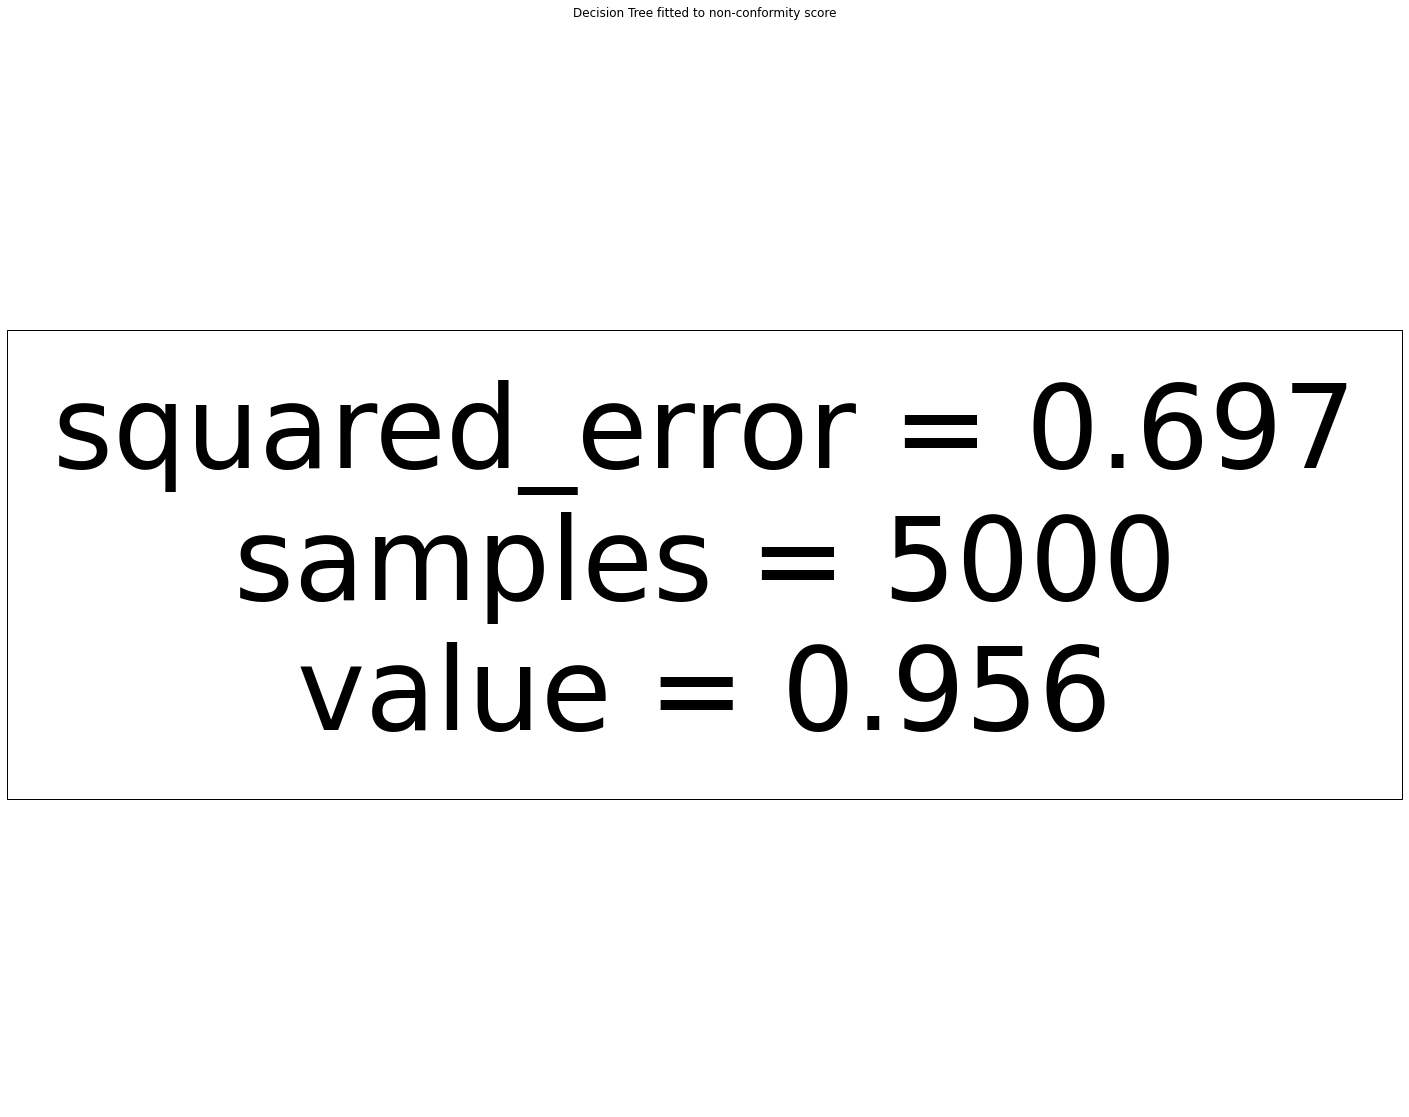

<Figure size 432x288 with 0 Axes>

In [15]:
values_t= compute_conformal_statistics(kind = "t_residuals", d = 20, t_degree= 6,
figname_tree = "locart_tree_asymmetric_RF_d_20_eta_1_5_split.pdf", B_x = 10000, split_calib = True, sig = 0.1, nbins = 10)

In [16]:
values_t[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.011739,0.903,0.009,0.901335,4.005855
1,LOCART,0.010637,0.902,0.008,0.900204,3.985375
2,Regresion split,0.010783,0.903,0.008,0.900195,3.986760
3,Weighted regression split,0.036751,0.905,0.031,0.899071,4.139653
4,Mondrian regression split,0.014593,0.901,0.012,0.899339,3.982210
5,Euclidean regression split,0.010641,0.902,0.008,0.900264,3.986266


Decreasing $\nu$ to 1.5:

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  51.817957401275635
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  2.648789405822754
Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  242.14178442955017
Fitting locart
Time Elapsed to fit Locart:  51.99223279953003
Computing metrics
Time Elapsed to compute metrics for Locart:  146.51837015151978
Fitting regression split
Time Elapsed to fit regression split:  36.62196898460388
Computing metrics
Time Elapsed to compute statistics for regression split:  0.6927027702331543
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  58.61817812919617
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.8339424133300781
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.561232328414917
Computing metrics
Time Elapsed to compute statistics for euclidean

<Figure size 720x432 with 0 Axes>

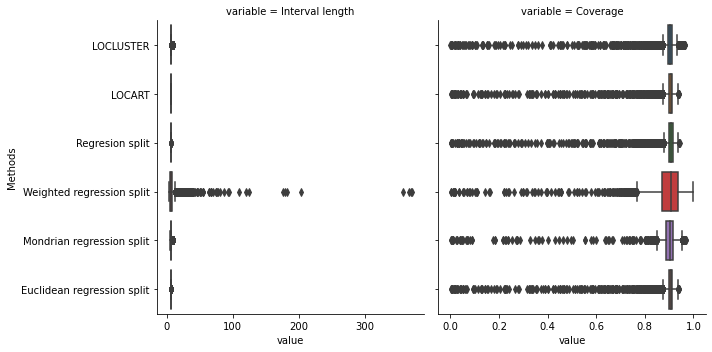

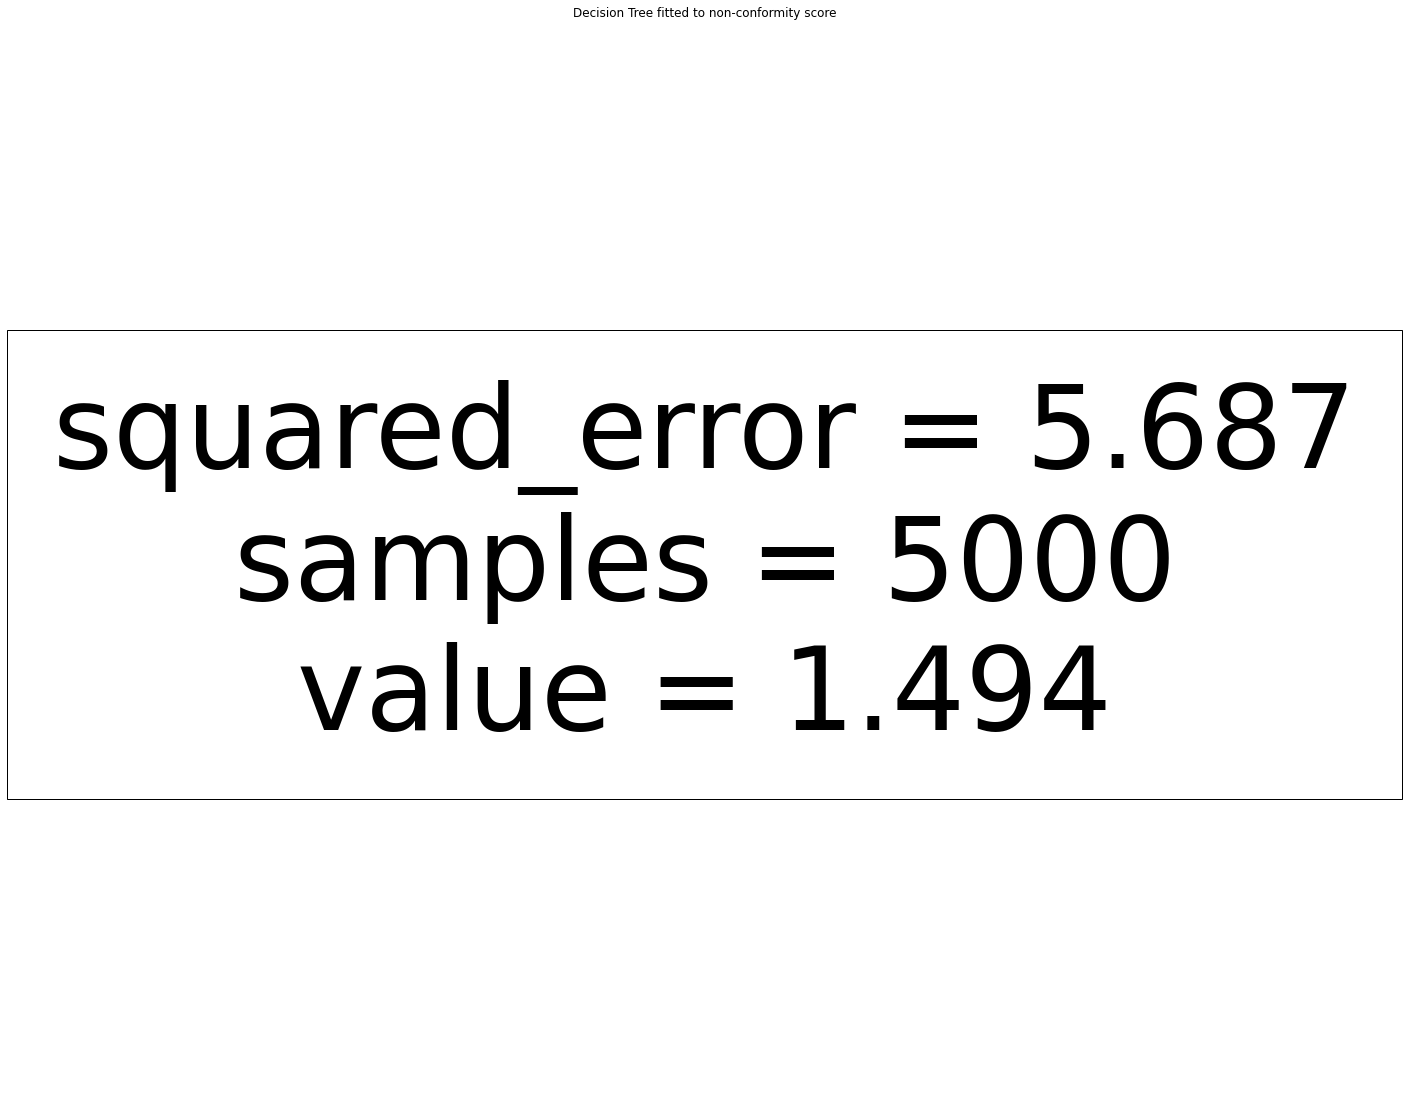

<Figure size 432x288 with 0 Axes>

In [17]:
values_t= compute_conformal_statistics(kind = "t_residuals", d = 20, t_degree= 2,
figname_tree = "locart_tree_asymmetric_RF_d_20_eta_1_5_split.pdf", B_x = 10000, split_calib = True, sig = 0.1, nbins = 10)

In [18]:
values_t[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.020076,0.905,0.009,0.895524,6.210807
1,LOCART,0.019930,0.906,0.010,0.895942,6.205246
2,Regresion split,0.020905,0.909,0.011,0.898742,6.304271
3,Weighted regression split,0.044098,0.907,0.035,0.897352,7.439167
4,Mondrian regression split,0.019744,0.902,0.013,0.898472,6.251618
5,Euclidean regression split,0.019867,0.906,0.009,0.895657,6.195987


### Weakly correlated heteroscedastic data

Fitting mondrian regression split
Time Elapsed to fit mondrian regression split:  45.49989700317383
Computing metrics
Time Elapsed to compute statistics for mondrian regression split:  2.091430187225342
Fitting locluster
Computing metrics
Time Elapsed to compute metrics for Locluster:  175.10446619987488
Fitting locart
Time Elapsed to fit Locart:  43.8814115524292
Computing metrics
Time Elapsed to compute metrics for Locart:  134.63480424880981
Fitting regression split
Time Elapsed to fit regression split:  43.341217279434204
Computing metrics
Time Elapsed to compute statistics for regression split:  0.6995561122894287
Fitting weighted regression split
Time Elapsed to fit weighted regression split:  56.325607776641846
Computing metrics
Time Elapsed to compute statistics for weighted regression split:  1.6700389385223389
Fitting euclidean regression split
Time Elapsed to fit euclidean regression split:  0.5257313251495361
Computing metrics
Time Elapsed to compute statistics for euclidea

<Figure size 720x432 with 0 Axes>

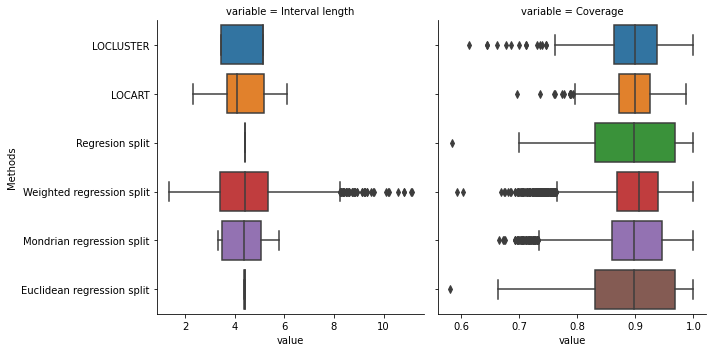

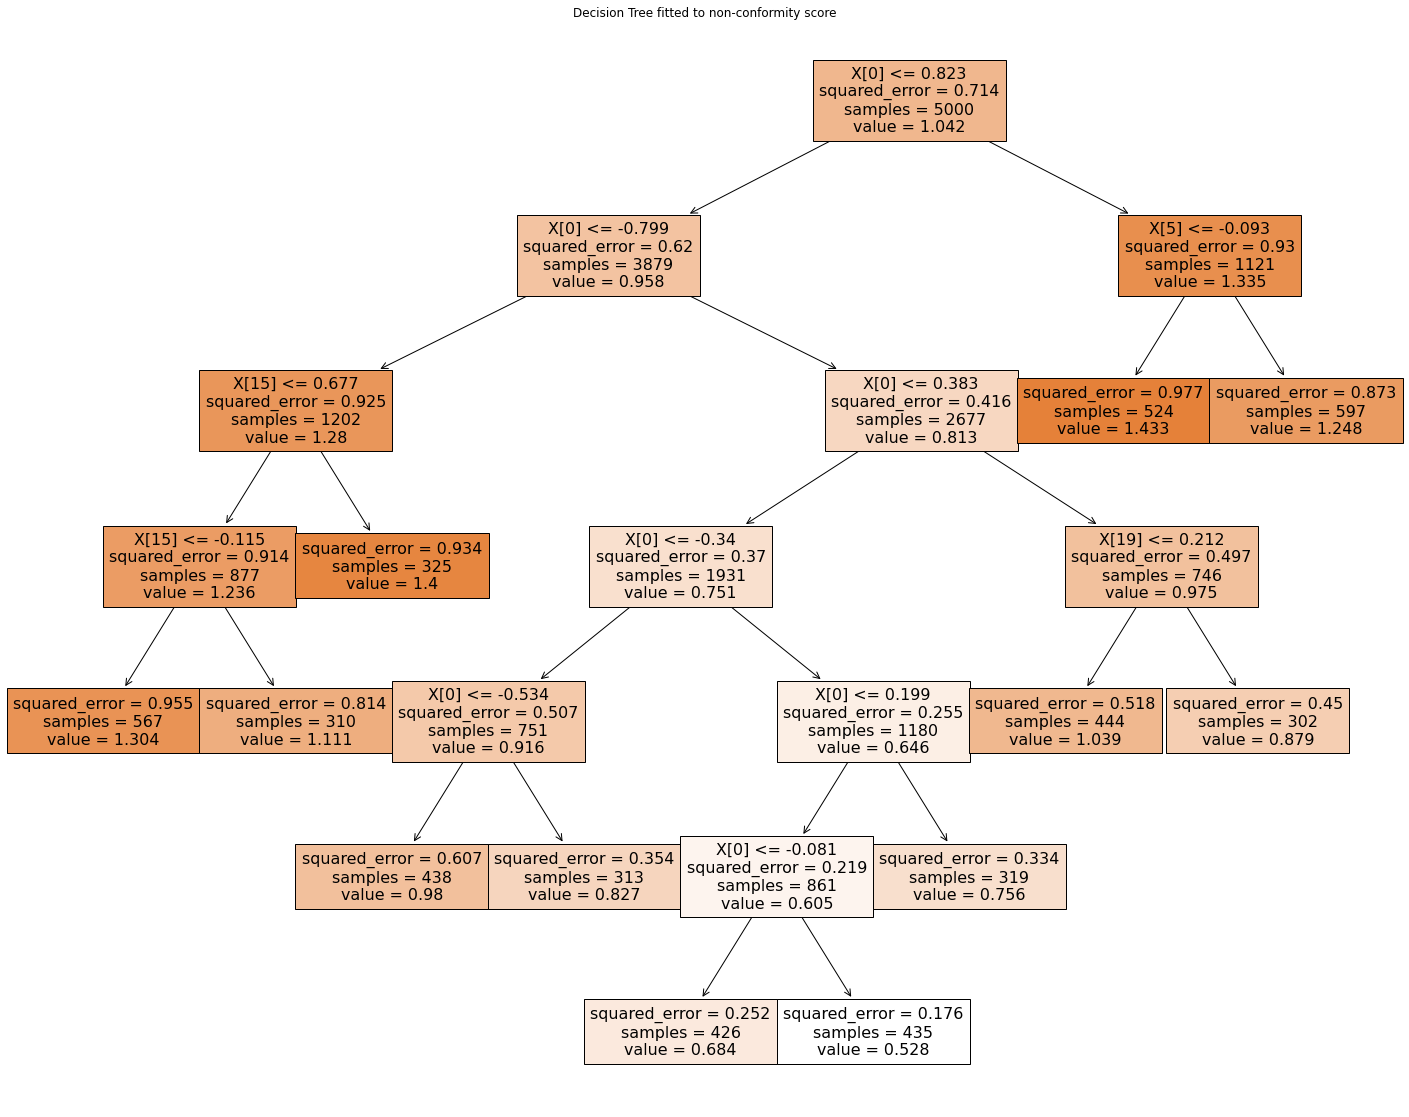

<Figure size 432x288 with 0 Axes>

In [19]:
values = compute_conformal_statistics(kind = "non_cor_heteroscedastic",
d = 20, figname_tree = "locart_tree_non_cor_heteroscedastic_RF_d_20_split.pdf", B_x = 10000, split_calib = True,
hetero_value = 0.25, sig = 0.1, nbins = 10)

In [20]:
values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.042405,0.899,0.037,0.900788,4.316205
1,LOCART,0.029083,0.900,0.026,0.898730,4.265746
2,Regresion split,0.066018,0.897,0.070,0.896444,4.394746
3,Weighted regression split,0.042049,0.907,0.036,0.900156,4.402171
4,Mondrian regression split,0.049027,0.898,0.042,0.899109,4.354237
5,Euclidean regression split,0.065926,0.897,0.070,0.896459,4.393171


### Quantilic score

We now change the score to the quantilic one, and compare our methods to cqr and raw quantilic regression:

#### Homoscedastic:

<Figure size 720x432 with 0 Axes>

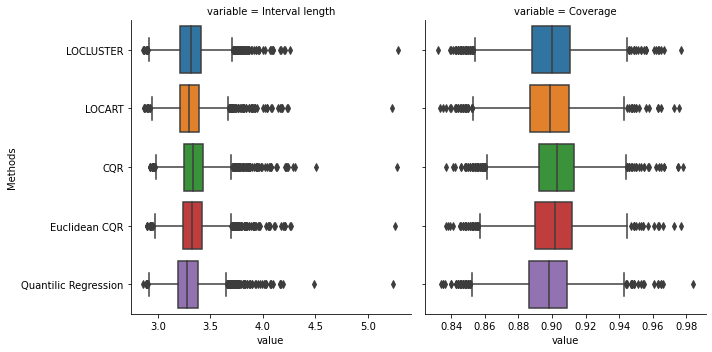

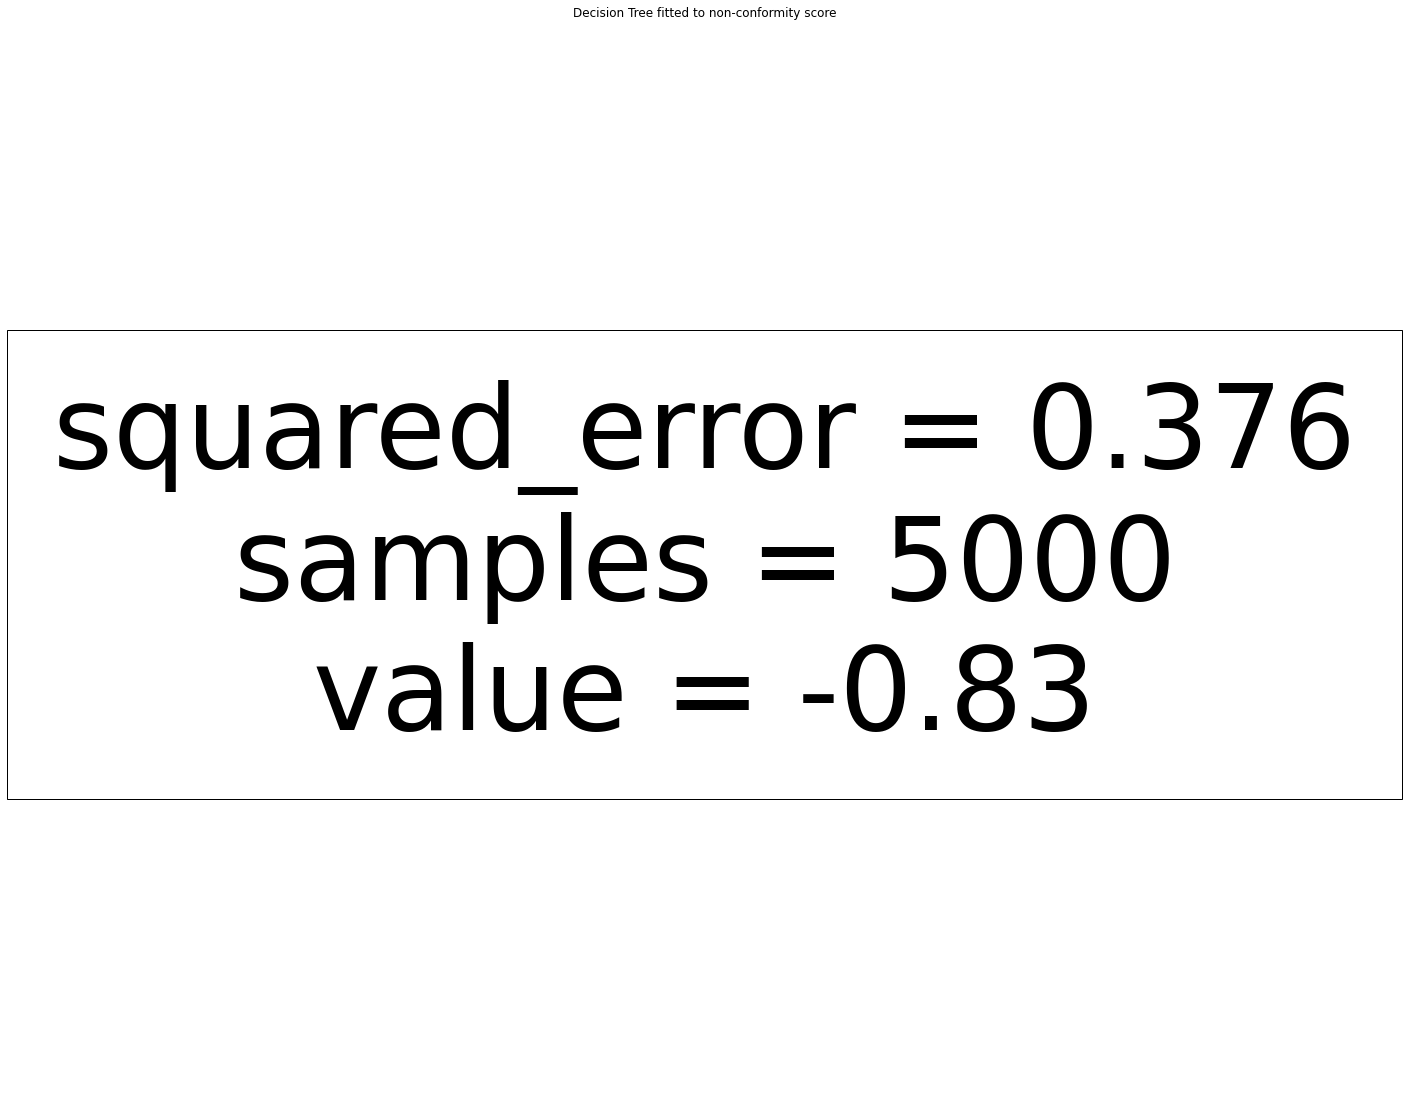

<Figure size 432x288 with 0 Axes>

In [32]:
locart_cov_values = compute_conformal_statistics(figname_tree = "locart_tree_homoscedastic_RF_d_20.pdf",
type_score = "quantile", base_model = QuantileGradientBoosting,
split_calib = True, B_x = 10000, sig  = 0.1)

In [33]:
locart_cov_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.013912,0.900,0.012,0.898978,3.307707
1,LOCART,0.013377,0.899,0.011,0.898072,3.299197
2,CQR,0.013122,0.903,0.011,0.902151,3.339257
3,Euclidean CQR,0.013114,0.902,0.011,0.900818,3.325852
4,Quantilic Regression,0.013705,0.898,0.011,0.896810,3.287052


#### Heteroscedastic

<Figure size 720x432 with 0 Axes>

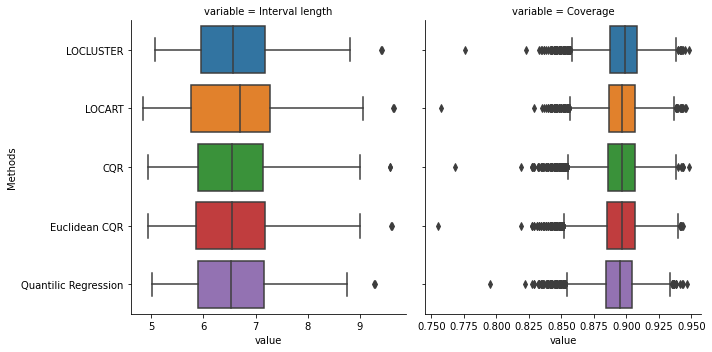

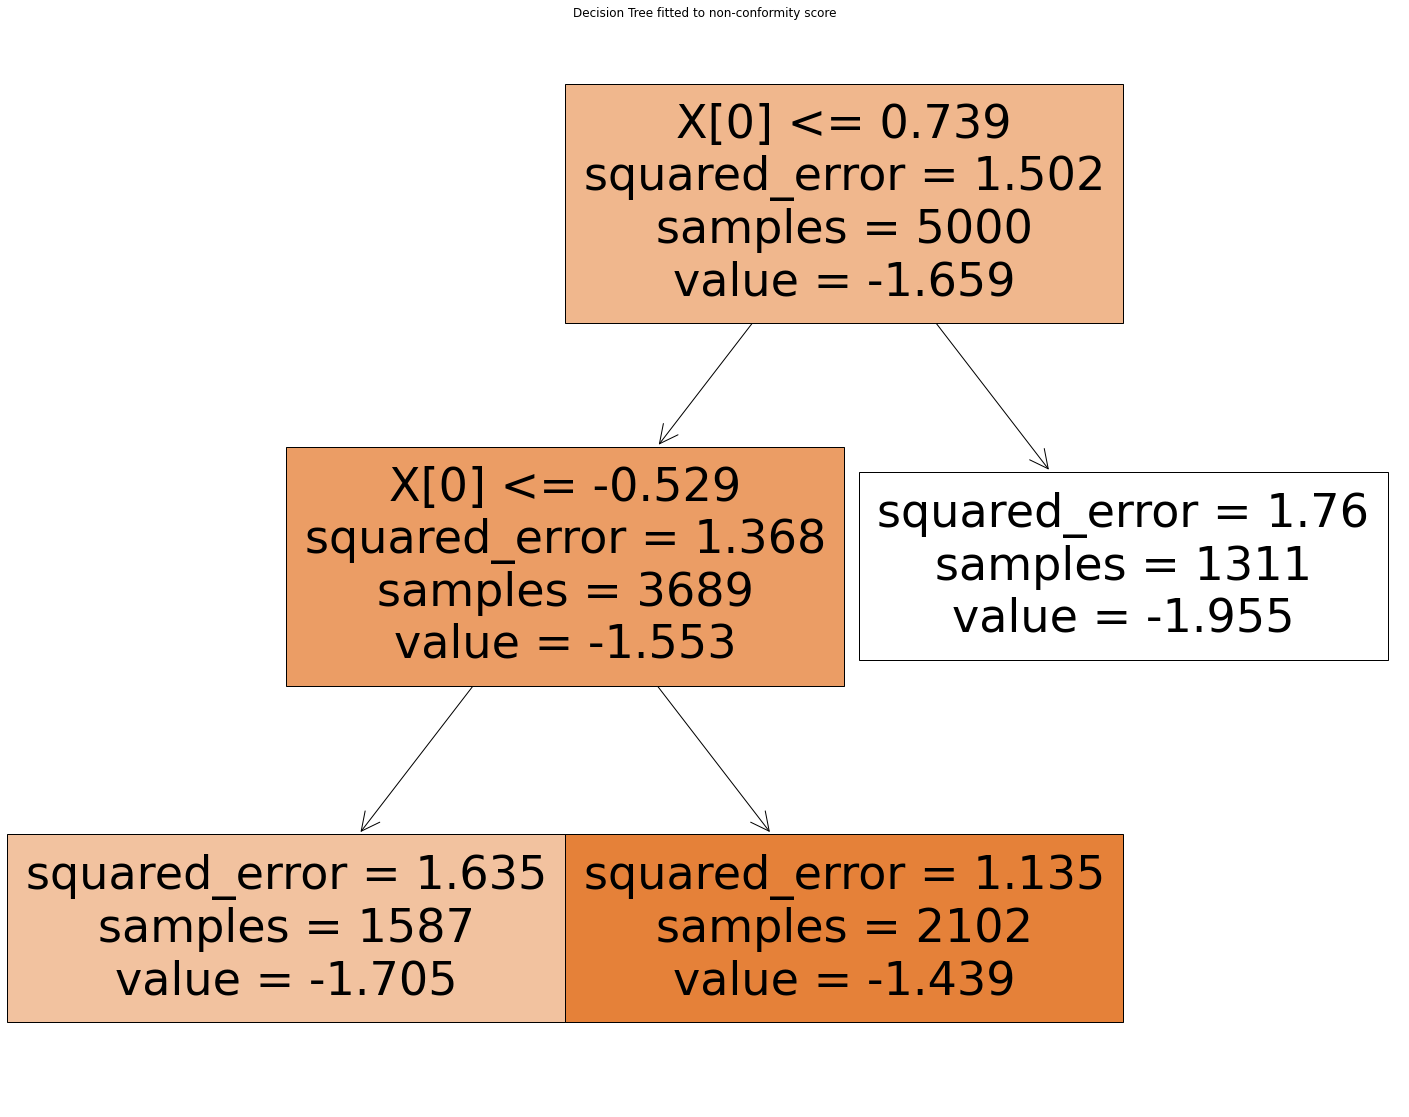

<Figure size 432x288 with 0 Axes>

In [13]:
heteroscedastic_values = compute_conformal_statistics(kind = "heteroscedastic", d = 30,
figname_tree = "locart_tree_heteroscedastic_RF_d_20_split.pdf", B_x = 10000,
split_calib = True,
type_score = "quantile", base_model = QuantileGradientBoosting,
hetero_value = 2.5, sig = 0.1)

In [14]:
heteroscedastic_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.012475,0.899,0.010,0.897298,6.561060
1,LOCART,0.012369,0.897,0.010,0.896667,6.555250
2,CQR,0.013100,0.897,0.011,0.895483,6.523793
3,Euclidean CQR,0.013088,0.897,0.011,0.895331,6.521772
4,Quantilic Regression,0.013237,0.895,0.011,0.893391,6.491615


Another heteroscedastic:

<Figure size 720x432 with 0 Axes>

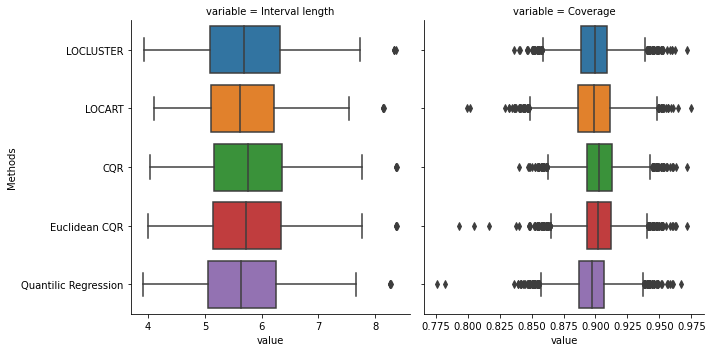

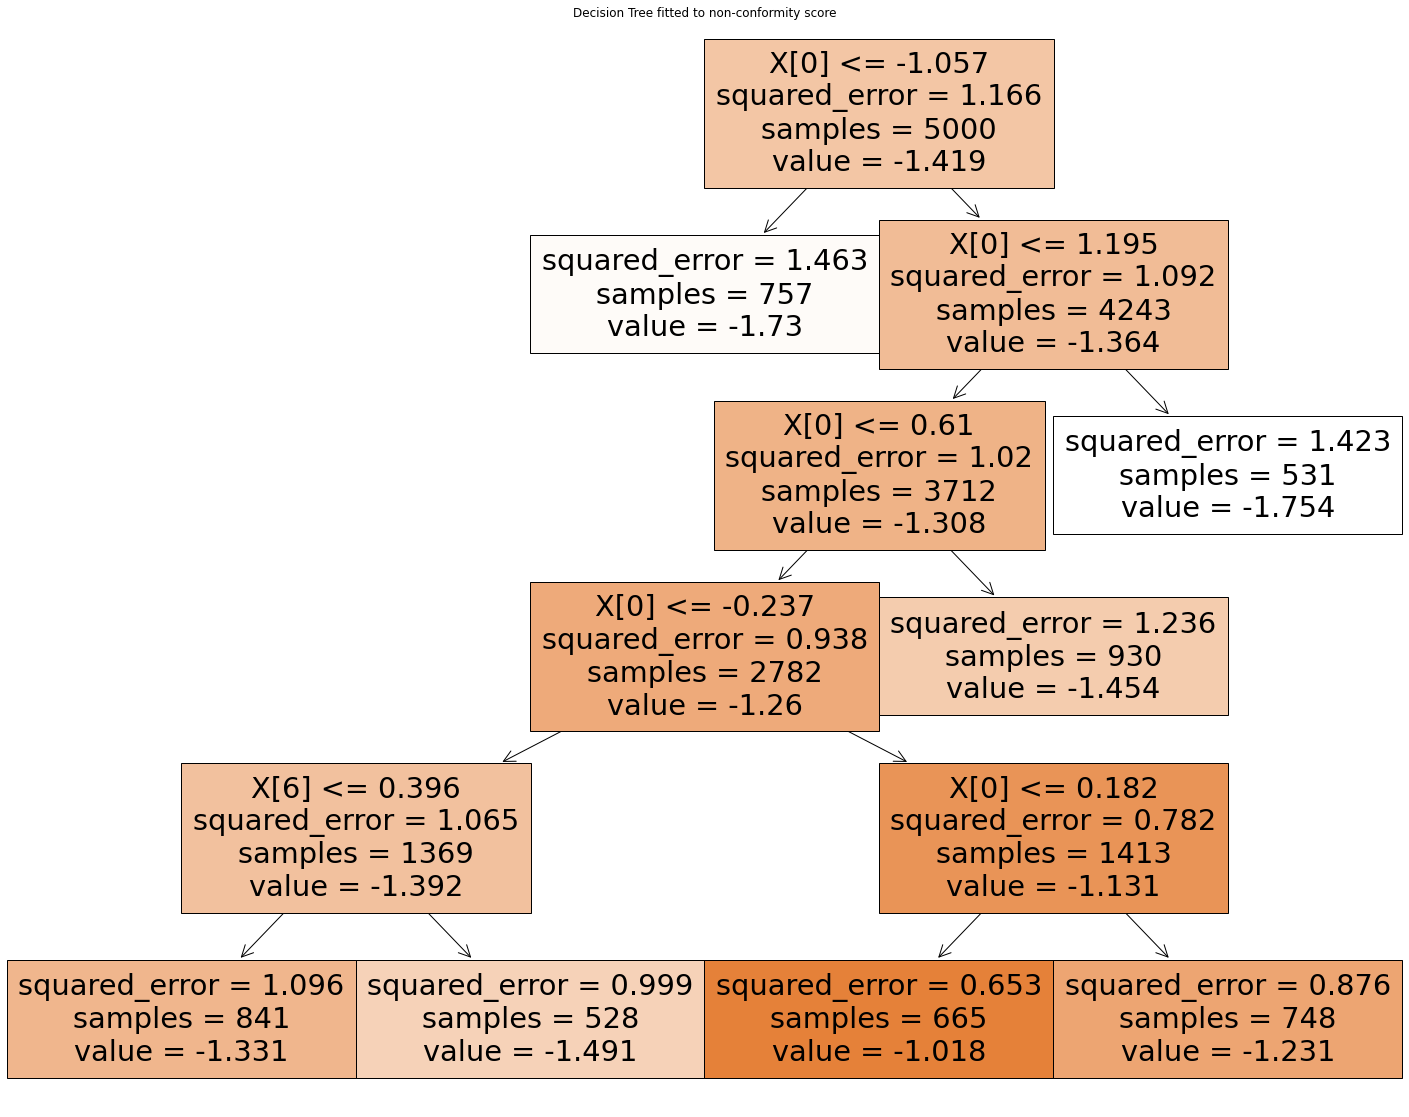

<Figure size 432x288 with 0 Axes>

In [9]:
heteroscedastic_values = compute_conformal_statistics(kind = "heteroscedastic", d = 20,
figname_tree = "locart_tree_heteroscedastic_RF_d_20_split.pdf", B_x = 10000,
split_calib = True,
type_score = "quantile", base_model = QuantileGradientBoosting,
min_samples_leaf = 500,
hetero_value = 1.5, sig = 0.1)

In [10]:
heteroscedastic_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.012129,0.900,0.010,0.899563,5.660014
1,LOCART,0.014412,0.899,0.012,0.898346,5.632127
2,CQR,0.012277,0.903,0.010,0.903435,5.723466
3,Euclidean CQR,0.012148,0.902,0.010,0.902559,5.709473
4,Quantilic Regression,0.012617,0.897,0.010,0.896966,5.617682


<Figure size 720x432 with 0 Axes>

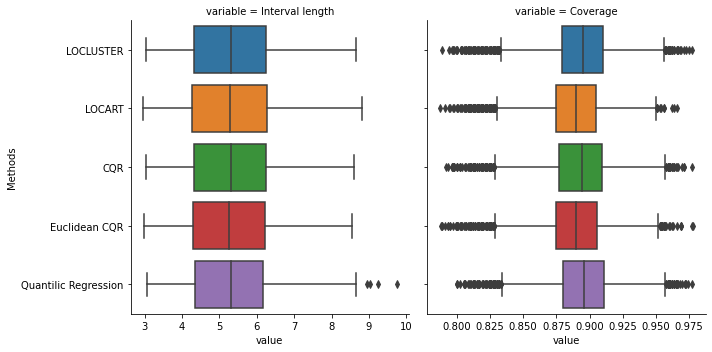

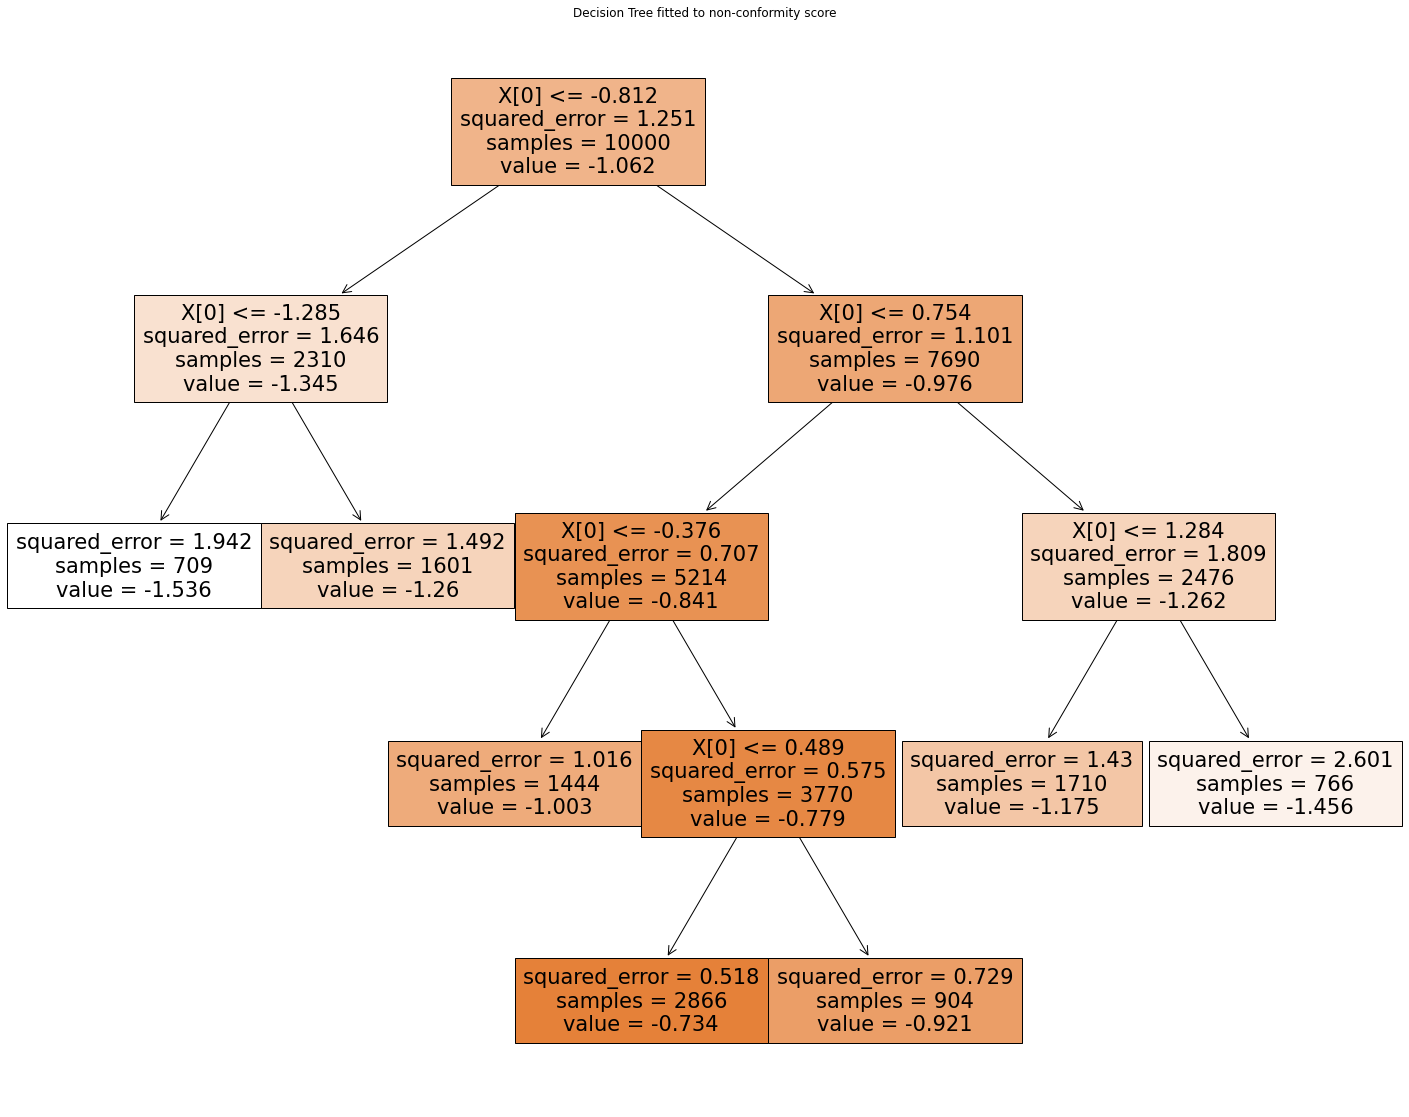

<Figure size 432x288 with 0 Axes>

In [7]:
asym_values = compute_conformal_statistics(kind = "asymmetric", d = 20,
figname_tree = "locart_tree_heteroscedastic_RF_d_20_split.pdf", B_x = 10000, split_calib = False,
asym_value = 0.6, type_score = "quantile", base_model = QuantileGradientBoosting, sig = 0.1)

In [8]:
asym_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.019478,0.895,0.016,0.894240,5.333981
1,LOCART,0.019945,0.890,0.016,0.889017,5.334074
2,CQR,0.019960,0.894,0.017,0.892828,5.328325
3,Euclidean CQR,0.020431,0.890,0.017,0.890062,5.310369
4,Quantilic Regression,0.019239,0.896,0.016,0.895219,5.339634


<Figure size 720x432 with 0 Axes>

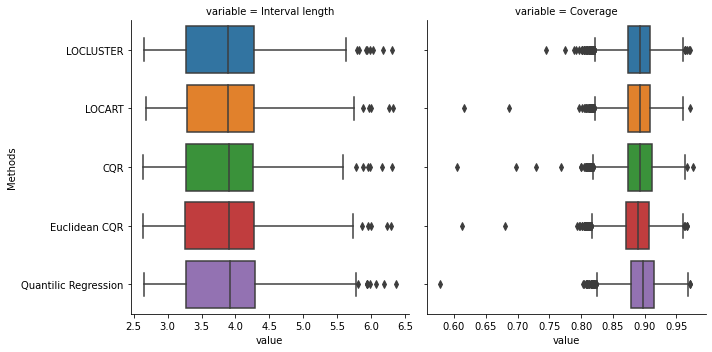

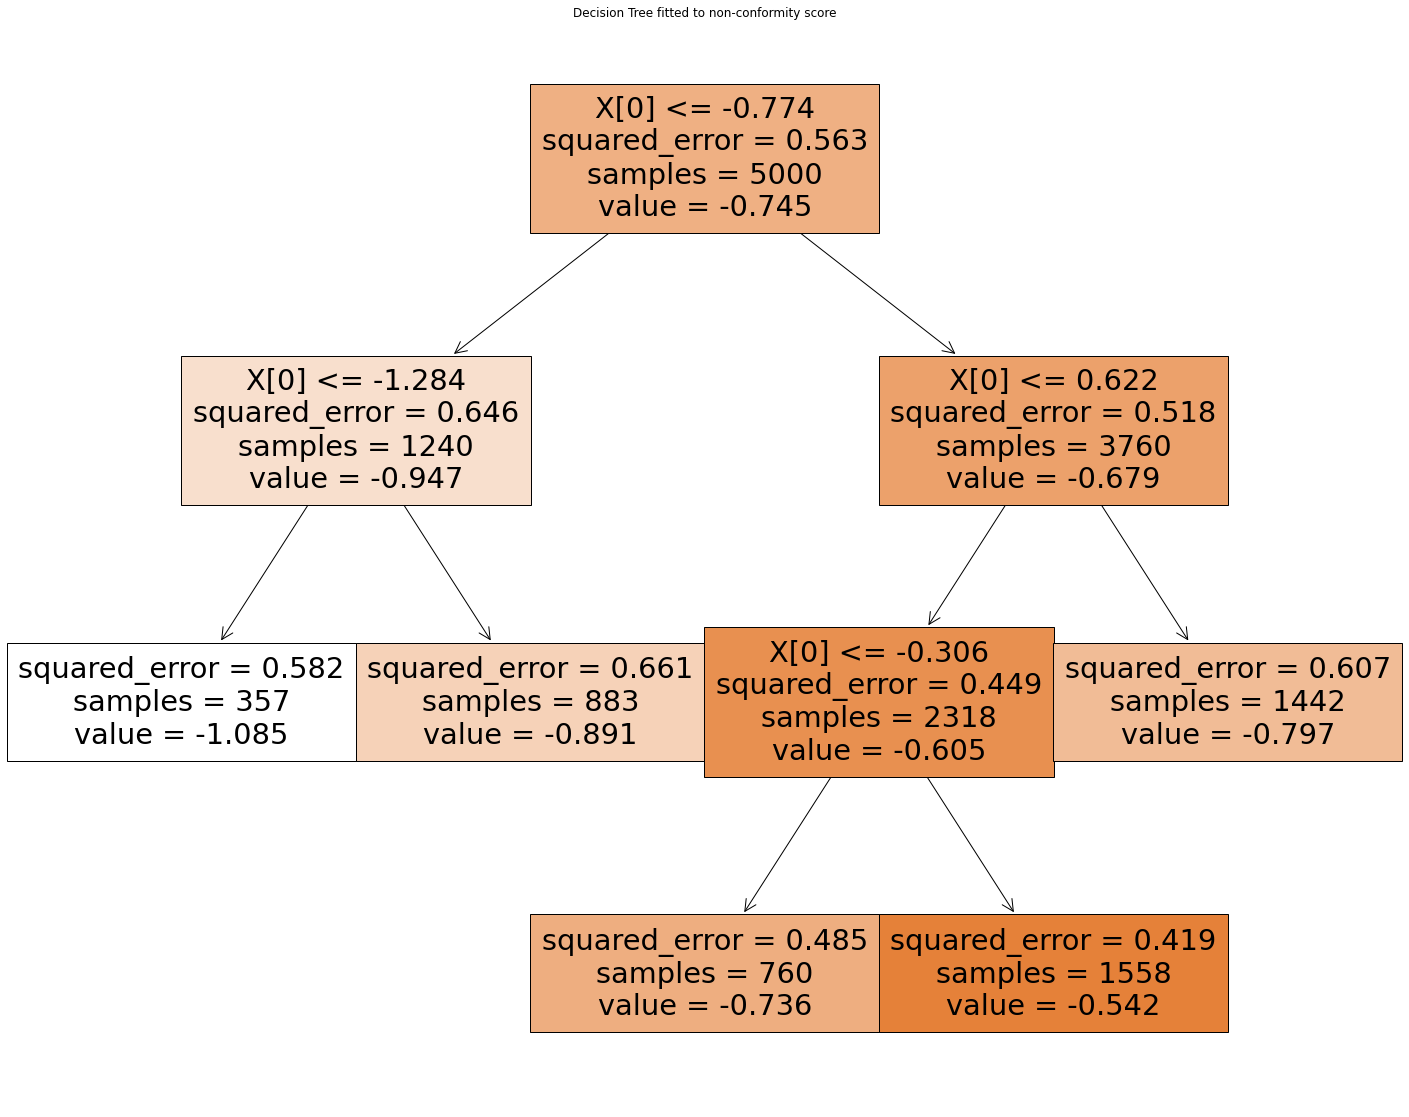

<Figure size 432x288 with 0 Axes>

In [48]:
heteroscedastic_values = compute_conformal_statistics(kind = "asymmetric", d = 20,
figname_tree = "locart_tree_heteroscedastic_RF_d_20_split.pdf", B_x = 10000, split_calib = True,
asym_value = 0.25, type_score = "quantile", base_model = QuantileGradientBoosting,
 sig = 0.1)

In [49]:
heteroscedastic_values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.021996,0.892,0.018,0.890817,3.886585
1,LOCART,0.021196,0.892,0.018,0.890878,3.886924
2,CQR,0.022125,0.893,0.019,0.892076,3.889990
3,Euclidean CQR,0.023044,0.890,0.019,0.888572,3.883005
4,Quantilic Regression,0.021095,0.897,0.018,0.896317,3.907150


<Figure size 720x432 with 0 Axes>

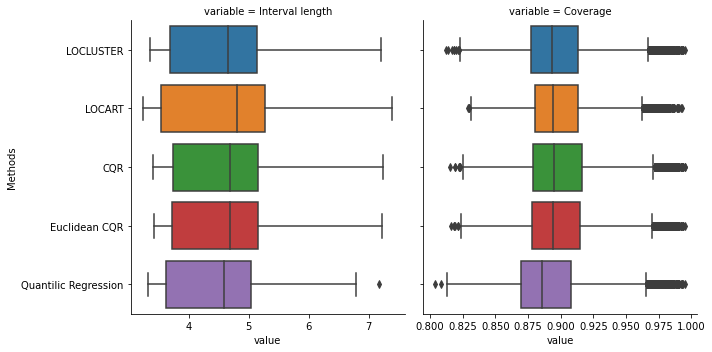

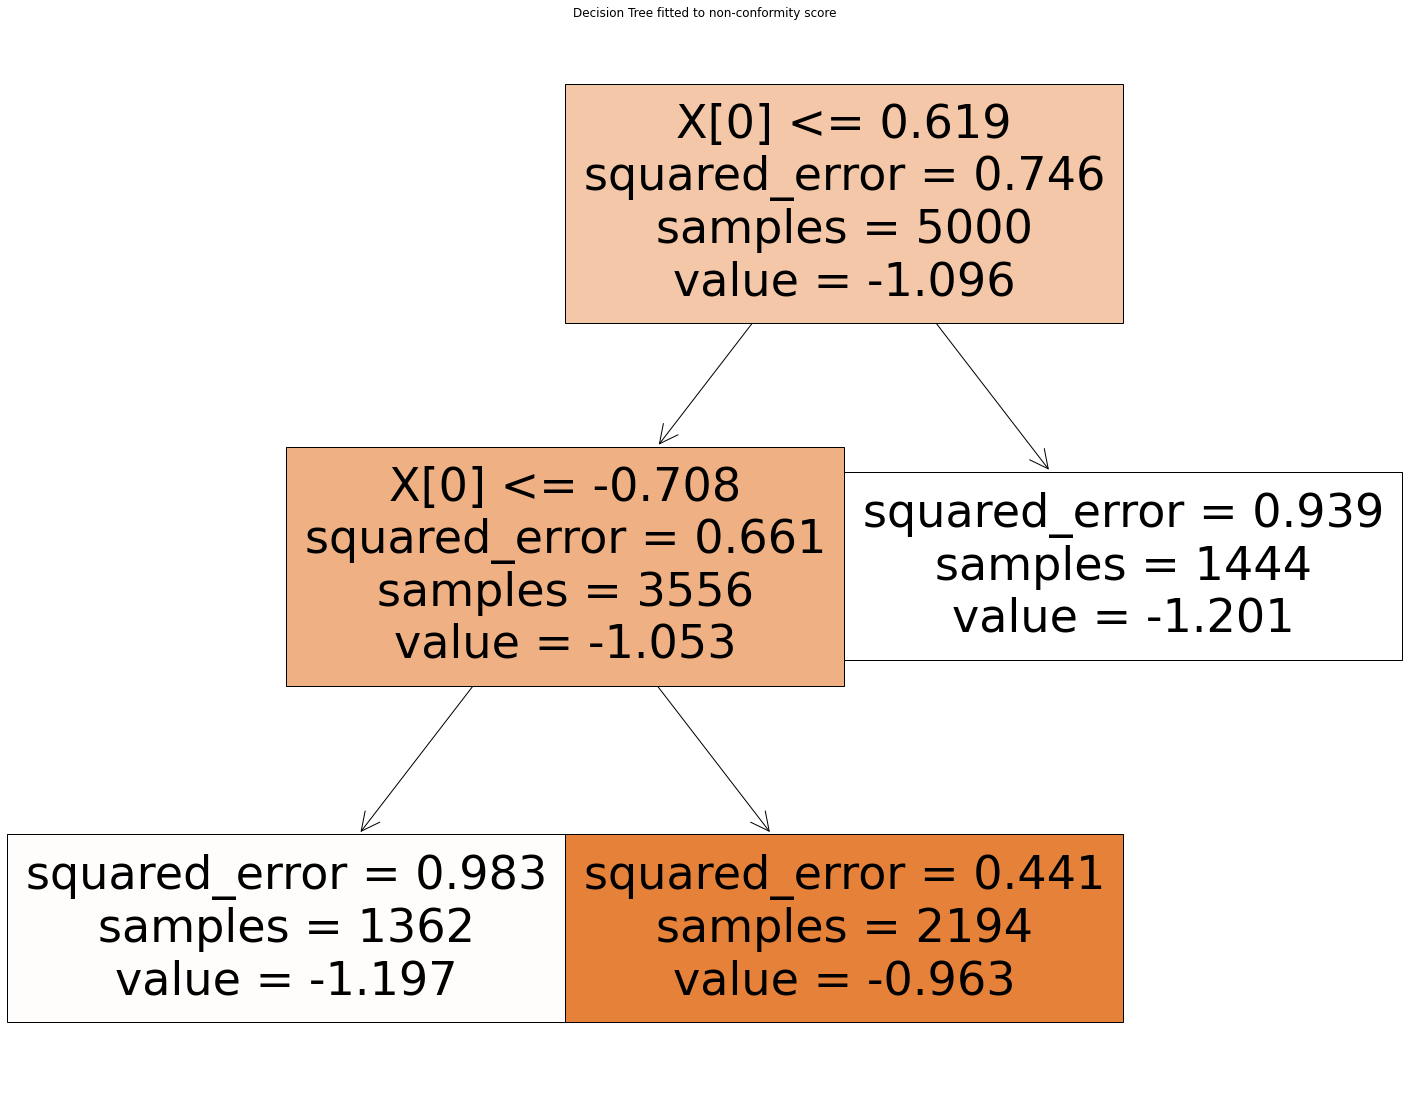

<Figure size 432x288 with 0 Axes>

In [52]:
values = compute_conformal_statistics(kind = "non_cor_heteroscedastic",
d = 20, figname_tree = "locart_tree_non_cor_heteroscedastic_RF_d_20_split.pdf", B_x = 10000, split_calib = True,
 type_score = "quantile", base_model = QuantileGradientBoosting,
hetero_value = 0.5, sig = 0.1)

In [53]:
values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.025560,0.893,0.020,0.898856,4.485116
1,LOCART,0.021979,0.894,0.017,0.899325,4.501993
2,CQR,0.025067,0.895,0.019,0.900971,4.514304
3,Euclidean CQR,0.025336,0.894,0.019,0.899910,4.499683
4,Quantilic Regression,0.028151,0.886,0.024,0.893160,4.410385


### Latent heteroscedastic

<Figure size 720x432 with 0 Axes>

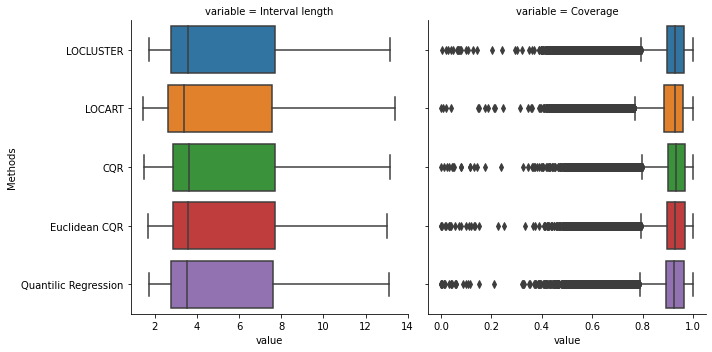

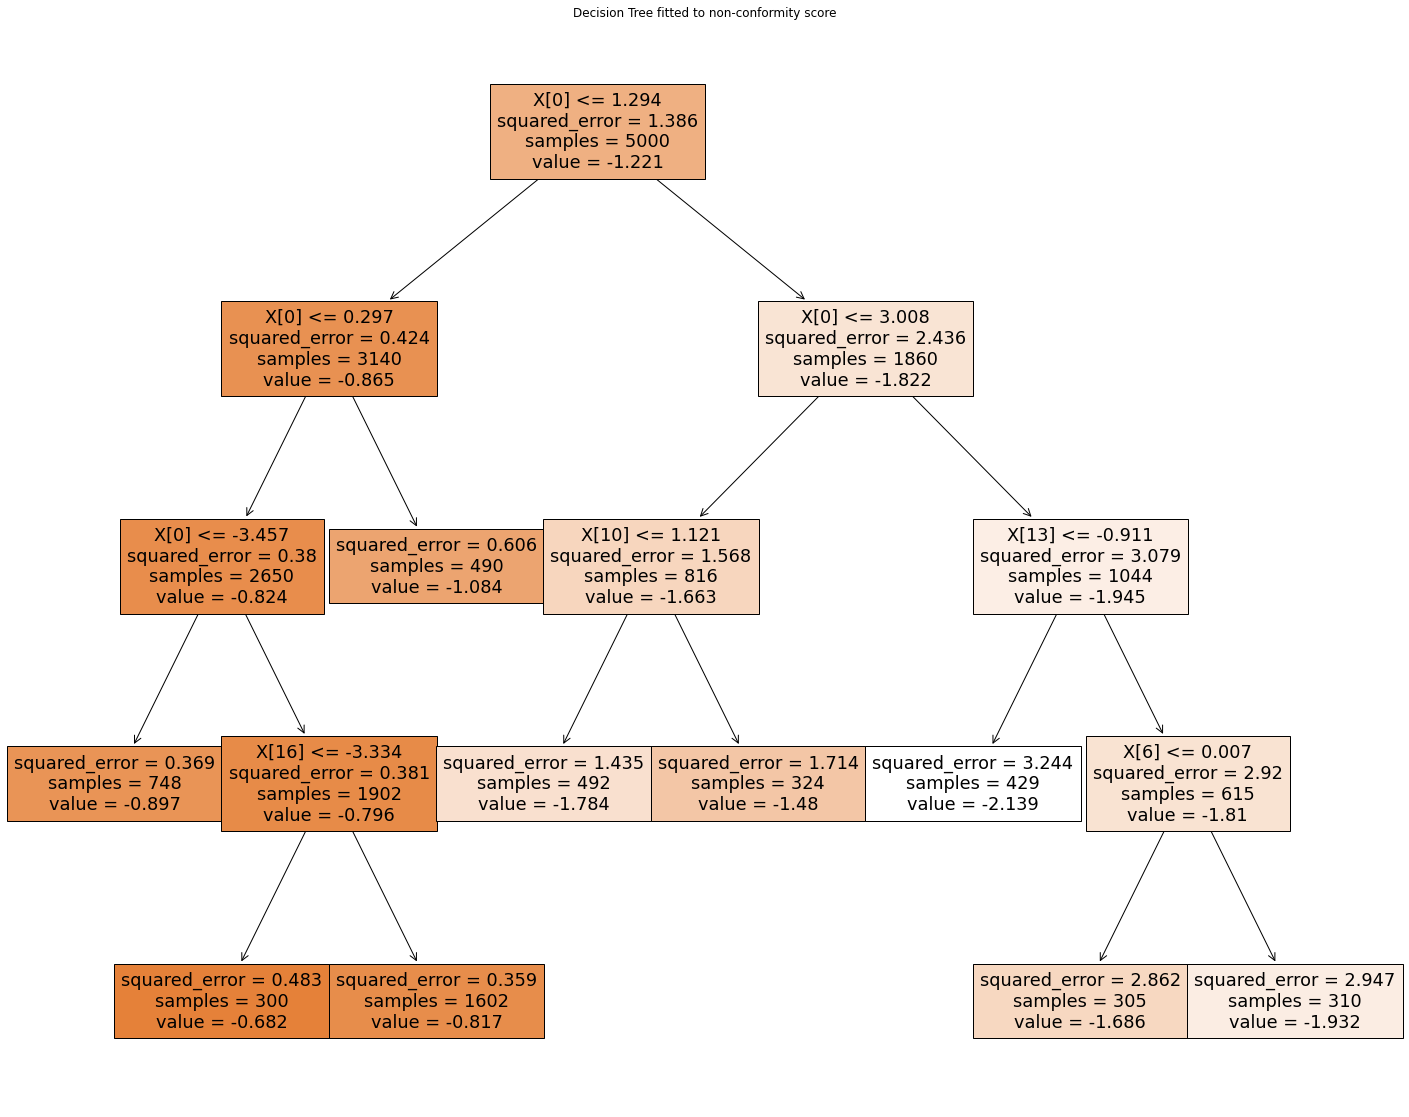

<Figure size 432x288 with 0 Axes>

In [3]:
values = compute_conformal_statistics(kind = "heteroscedastic_latent",
d = 20, figname_tree = "locart_tree_heteroscedastic_latent_RF_d_20_split.pdf", B_x = 10000, split_calib = True,
type_score = "quantile", base_model = QuantileGradientBoosting, sig = 0.1)

In [4]:
values[0]

,Methods,Average distance,Median conditional coverage,Median distance,Average marginal coverage,Average interval length
0,LOCLUSTER,0.081940,0.929,0.050,0.891818,5.276489
1,LOCART,0.078989,0.927,0.048,0.891566,5.253968
2,CQR,0.079432,0.931,0.052,0.898356,5.382058
3,Euclidean CQR,0.080176,0.929,0.051,0.896124,5.361126
4,Quantilic Regression,0.081663,0.926,0.049,0.890790,5.301386
